In [3]:
import numpy as np
import pandas as pd
import csv 
import matplotlib.pyplot as plt
import wandb

# RDKit
import rdkit 
from rdkit import Chem
from rdkit.Chem import AllChem

import torch
import networkx as nx

from typing import Optional, List, Union, Tuple


In [14]:
X_train = pd.read_csv('./data/raw_data/X_train.csv',index_col=0)
y_train = pd.read_csv('./data/raw_data/y_train.csv', index_col=0)

# You can check the shapes of the train and test sets
#print(f"The train test contains {train.shape[0]} molecules.")
#print(f"The test test contains {test.shape[0]} molecules.")
# You can check what it looks like
#train.head()

In [40]:
def smiles_to_graph(smiles: str) -> Optional[nx.Graph]:
    mol = Chem.MolFromSmiles(smiles) #construct molecules from smile notations
    if mol is None:
        return None

    # Convertir la molécule RDKit en graphe NetworkX
    g = nx.Graph()
    for atom in mol.GetAtoms(): #loop over the atoms
        g.add_node(atom.GetIdx(), atom_type=atom.GetSymbol())

    for bond in mol.GetBonds(): #loop over the bonds 
        g.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondTypeAsDouble())

    return g

def process_csv(file_path: str) -> List[Union[nx.Graph, None]]:
    graphs: List[Union[nx.Graph, None]] = []

    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)

        # Ignorer la première ligne (entêtes)
        next(csv_reader, None)

        for row in csv_reader:
            # Supposons que la colonne contenant les SMILES soit appelée "smiles"
            smiles_column_index = 1  # Indice de la deuxième colonne (0-indexed)

            if len(row) > smiles_column_index:
                smiles = row[smiles_column_index]
                mol_graph = smiles_to_graph(smiles)
                graphs.append(mol_graph)

    return graphs

In [41]:
# Exemple d'utilisation
file_path = "./data/X_train.csv"
mol_graphs = process_csv(file_path)

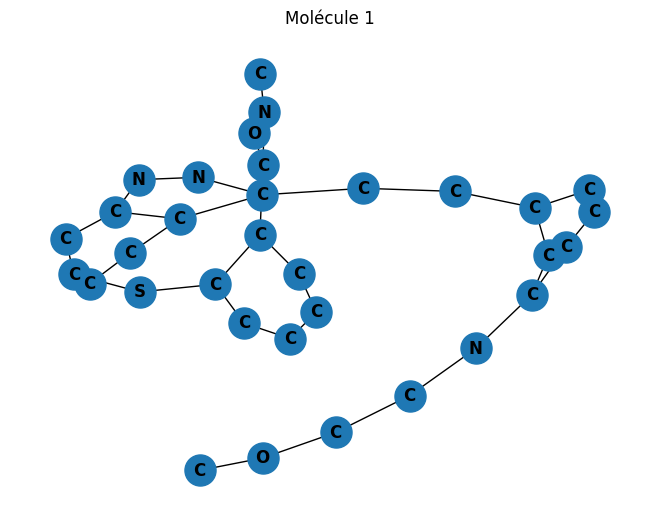

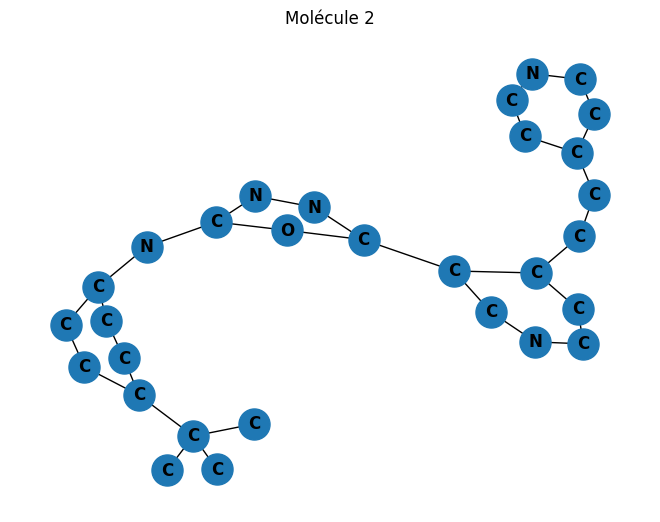

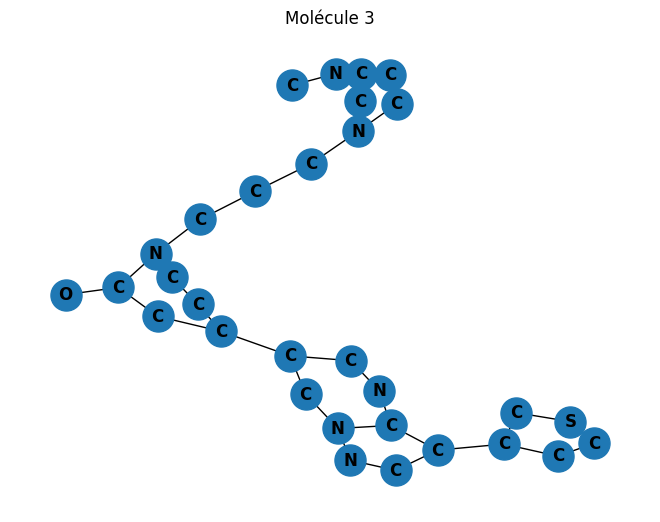

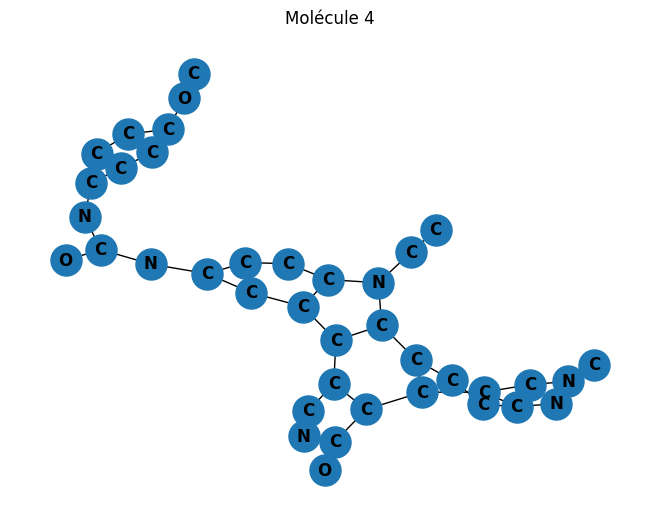

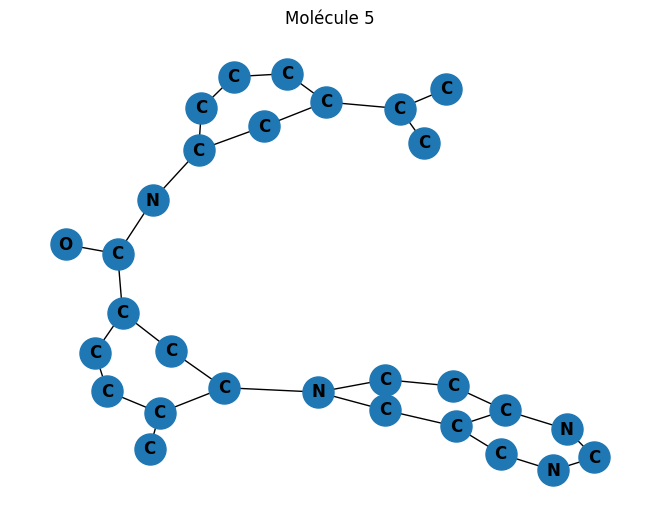

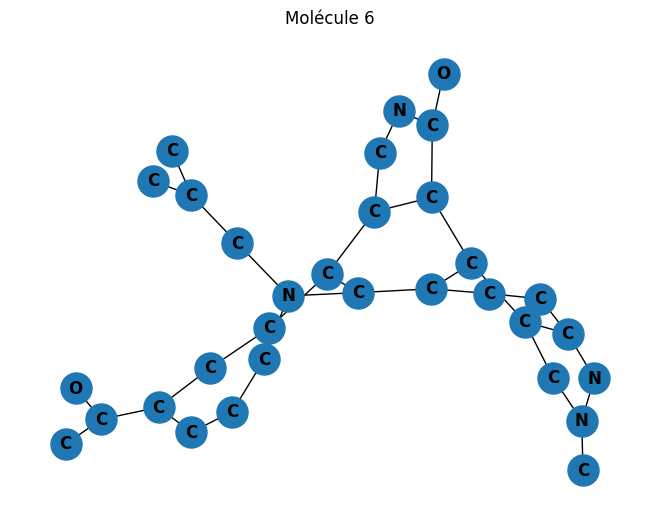

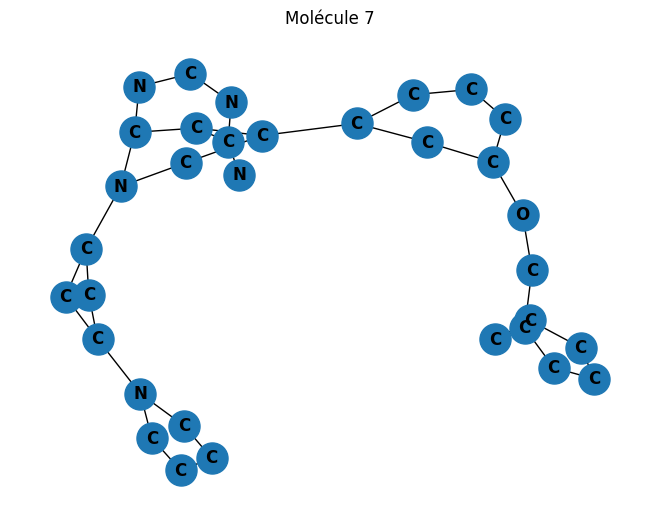

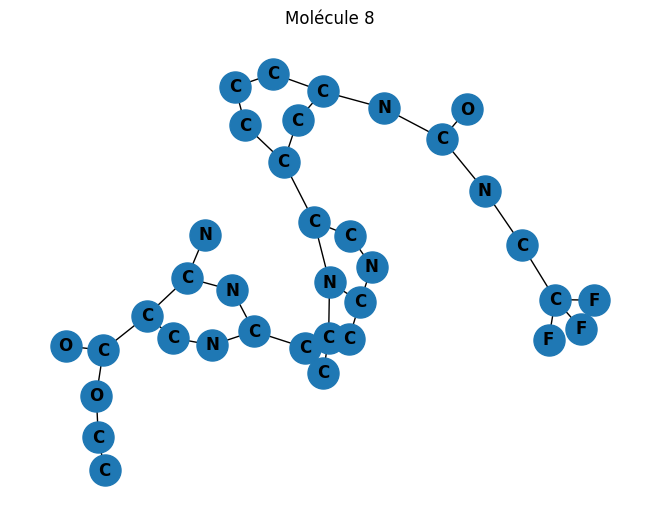

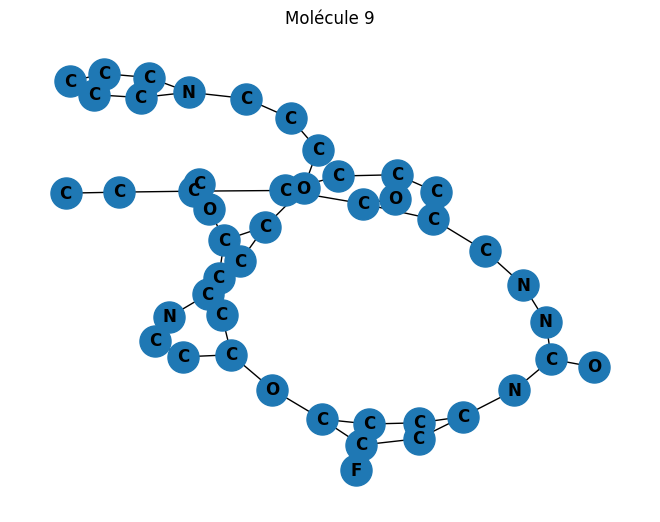

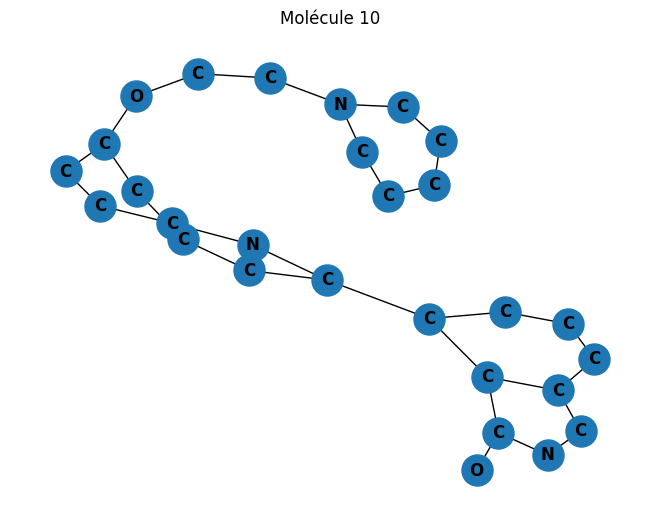

In [43]:
def visualize_graph(graph: nx.Graph, title: str = ""):
    pos = nx.spring_layout(graph)

    # Obtenez les étiquettes des nœuds (symboles d'atomes)
    node_labels = {node: graph.nodes[node]['atom_type'] for node in graph.nodes}
    nx.draw(graph, pos, with_labels=True, font_weight='bold', node_size=500, labels=node_labels)
    plt.title(title)
    plt.show()

for i, mol_graph in enumerate(mol_graphs[:10]):
    if mol_graph is not None:
        visualize_graph(mol_graph, title=f"Molécule {i+1}")

In [21]:
# Fusionner les données en fonction de l'identifiant unique des molécules
merged_data = pd.merge(X_train, y_train, on="id")

# Afficher les premières lignes du jeu de données fusionné
print(merged_data.head())

                                               smiles         y
id                                                             
0   CNC(=O)c1ccccc1Sc1ccc2c(C#Cc3cccc(NCCOC)c3)n[n...  7.882729
1     CC(C)(C)c1ccc(Nc2nnc(-c3cnccc3CCc3ccncc3)o2)cc1  6.508498
2   CN1CCN(CCCn2ccc(-c3cnc4c(-c5ccsc5)cnn4c3)cc2=O...  8.148742
3   CCn1c2ccc(NC(=O)Nc3ccc(OC)cc3)cc2c2c3c(c4c(c21...  7.954677
4      Cc1ccc(C(=O)Nc2cccc(C(C)C)c2)cc1N1CCc2ncncc2C1  7.954677


In [ ]:
merged_data.to_csv('./data/raw_data/train_merged_data.csv')

In [61]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset

In [97]:
# Classe MolDataset pour PyTorch Geometric
class MolDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        mol_graph = smiles_to_graph(row['smiles'])

        x = torch.tensor([[0.0] for _ in range(len(mol_graph.nodes))], dtype=torch.float32)

        # Construct edge_index from the adjacency matrix of the graph
        edge_index = torch.tensor(list(mol_graph.edges), dtype=torch.long).t().contiguous()

        # Utilisez row['target_property'] pour obtenir la propriété cible
        target_property = torch.tensor(row['y'], dtype=torch.float32)

        return Data(
            x=x,
            edge_index=edge_index,
            y=target_property
        )



In [98]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(merged_data, test_size=0.2, random_state=42)
train_dataset = MolDataset(train_data)
test_dataset = MolDataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# If you use GPU, the device should be cuda
print('Device: {}'.format(device))


Device: cpu


In [101]:
# Print the type of the first batch
for batch in train_dataloader:
    print("Type of the batch:", type(batch))
    break  # Only print the first batch

Type of the batch: <class 'torch_geometric.data.batch.DataBatch'>


In [102]:
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import MessagePassing
# Define Molecular Attention Transformer model
class MultiHeadAttentionLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, num_heads):
        super(MultiHeadAttentionLayer, self).__init__(aggr='add')
        self.num_heads = num_heads
        self.head_dim = out_channels // num_heads
        self.linear = nn.Linear(in_channels, out_channels)
        self.att = None

    def forward(self, x, edge_index):
        x = self.linear(x)
        return self.propagate(edge_index, x=x)

def message(self, x_i, x_j, edge_index, size_i):
    # Compute attention coefficients.
    if torch.is_tensor(size_i):  # Check if size_i is a tensor
        size_i = size_i.unsqueeze(1) if size_i.dim() == 0 else size_i
    else:
        size_i = torch.tensor(size_i, dtype=torch.float32).unsqueeze(1)  # Convert scalar to tensor

    alpha = (x_i * x_j).sum(dim=-1) / (size_i.unsqueeze(1) * size_i.unsqueeze(0))
    alpha = torch.softmax(alpha / (self.head_dim ** 0.5), dim=0)
    self.att = alpha  # Save attention coefficients for visualization (optional)
    return x_j * alpha.unsqueeze(-1)


    def update(self, aggr_out):
        return aggr_out

class MATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(MATModel, self).__init__()
        self.attention = MultiHeadAttentionLayer(input_dim, hidden_dim, num_heads)
        self.fc1 = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.attention(x, edge_index)
        x = torch.relu(x)
        x = self.fc1(x)
        return x


### Implementation of GIN

In [118]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool

In [121]:
#adapted from https://mlabonne.github.io/blog/posts/2022-04-25-Graph_Isomorphism_Network.html to use it for a regression task
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h, num_node_features):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, 1)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = self.lin2(h)
        
        return h

In [122]:
# Configuration de WandB
import os 

#os.environ["WANDB_API_KEY"] = "your_wandb_api_key"
wandb.init(project="gnn_pred", name="1st gin attempt")

In [125]:
# Paramètres du modèle et de l'entraînement
input_dim = 1  # À ajuster en fonction de vos données
hidden_dim = 256
output_dim = 1

model = GIN(hidden_dim, input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [127]:
# Boucle d'entraînement
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()
        x, edge_index, batch_data = batch.x, batch.edge_index, batch.batch

        # Ajoutez batch_data à votre modèle GIN (s'il est nécessaire)
        output = model(x, edge_index, batch_data)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")

    # Log WandB
    wandb.log({"loss": average_loss})

wandb.finish()

/mnt/c/Users/lacar/desktop/ensae/m2/advanced_ml/Projet/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 822.0633974931457
Epoch 2/100, Loss: 2.0805453354662116
Epoch 3/100, Loss: 2.0429701631719417
Epoch 4/100, Loss: 2.0716786189512773
Epoch 5/100, Loss: 2.034885783628984
Epoch 6/100, Loss: 2.1356668775731866
Epoch 7/100, Loss: 2.1568838076158
Epoch 8/100, Loss: 2.052190352569927
Epoch 9/100, Loss: 2.132167621634223
Epoch 10/100, Loss: 1.9919425942681053
Epoch 11/100, Loss: 2.061028949780898
Epoch 12/100, Loss: 2.0054780808362094
Epoch 13/100, Loss: 2.019034760648554
Epoch 14/100, Loss: 1.9619473403150385
Epoch 15/100, Loss: 1.923616389794783
Epoch 16/100, Loss: 2.122783660888672
Epoch 17/100, Loss: 1.956801197203723
Epoch 18/100, Loss: 2.0090324781157753
Epoch 19/100, Loss: 1.9242085099220276
Epoch 20/100, Loss: 1.9511928233233364
Epoch 21/100, Loss: 1.9870637839490717
Epoch 22/100, Loss: 1.9365762732245706
Epoch 23/100, Loss: 2.0264044003053145
Epoch 24/100, Loss: 1.9044673350724306
Epoch 25/100, Loss: 1.9113859350031073
Epoch 26/100, Loss: 1.8713501485911284
Epoch 2

loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1.75827


### Optimisation des hyperparamètres 

In [142]:
import optuna 
from tqdm import tqdm 
def objective(trial):
    # Définissez les hyperparamètres à optimiser
    hidden_dim = trial.suggest_int('hidden_dim', 32, 512)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    # Log les hyperparamètres avec wandb
    wandb.config.update({
        'hidden_dim': hidden_dim,
        'learning_rate': learning_rate,
    })

    # Instanciez le modèle avec les hyperparamètres
    model = GIN(hidden_dim, input_dim)

    # Définissez l'optimiseur avec le taux d'apprentissage
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Boucle d'entraînement avec validation
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in test_dataloader:
            optimizer.zero_grad()

            # Assurez-vous que batch contient x, edge_index, et batch
            x, edge_index, batch_data = batch.x, batch.edge_index, batch.batch

            # Ajoutez batch_data à votre modèle GIN (s'il est nécessaire)
            output = model(x, edge_index, batch_data)

            loss = criterion(output, batch.y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(test_dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")

        # Log WandB
        wandb.log({"loss": average_loss})

    # Retournez la MSE sur l'ensemble de validation
    return average_loss

In [143]:
# Configuration de WandB
import os 

#os.environ["WANDB_API_KEY"] = "your_wandb_api_key"
wandb.init(project="gnn_pred", name=" gin attempt with hyperparam optimisation")

loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1.82828


In [144]:
input_dim = 1  # À ajuster en fonction de vos données
hidden_dim = 256
output_dim = 1
epochs = 100

# Créez votre DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Créez l'étude Optuna
study = optuna.create_study(direction='minimize')
for trial in tqdm(study.optimize(objective, n_trials=50), desc="Optimizing"):
    pass

# Affichez les résultats de l'optimisation
print('Best trial:')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-12-17 05:43:47,199] A new study created in memory with name: no-name-cfb061d1-0706-450e-ab41-b4aae27a9e64
/tmp/ipykernel_86016/85855212.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/mnt/c/Users/lacar/desktop/ensae/m2/advanced_ml/Projet/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/mnt/c/Users/lacar/desktop/ensae/m2/advanced_ml/Projet/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that i

Epoch 1/100, Loss: 947.3998384475708
Epoch 2/100, Loss: 3.0533155415739333
Epoch 3/100, Loss: 2.9012980801718578
Epoch 4/100, Loss: 2.7725291209561482
Epoch 5/100, Loss: 2.639094263315201
Epoch 6/100, Loss: 2.4802012188094005
Epoch 7/100, Loss: 2.257374312196459
Epoch 8/100, Loss: 2.205333020005907
Epoch 9/100, Loss: 2.212939773287092
Epoch 10/100, Loss: 2.28563278062003
Epoch 11/100, Loss: 2.3519501856395175
Epoch 12/100, Loss: 2.1648457050323486
Epoch 13/100, Loss: 1.9936708850519997
Epoch 14/100, Loss: 2.119164058140346
Epoch 15/100, Loss: 2.366667411157063
Epoch 16/100, Loss: 2.0168399470193044
Epoch 17/100, Loss: 2.117415006671633
Epoch 18/100, Loss: 1.9883026310375758
Epoch 19/100, Loss: 1.9766937451703208
Epoch 20/100, Loss: 2.0122387366635457
Epoch 21/100, Loss: 1.965557920081275
Epoch 22/100, Loss: 2.0110676416328976
Epoch 23/100, Loss: 2.013888989176069
Epoch 24/100, Loss: 2.0115021084036147
Epoch 25/100, Loss: 2.014378641332899
Epoch 26/100, Loss: 2.0155668471540724
Epoch 27

wandb: Network error (ConnectionError), entering retry loop.


Epoch 75/100, Loss: 1.9082480732883726
Epoch 76/100, Loss: 1.9369724478040422
Epoch 77/100, Loss: 1.957551739045552
Epoch 78/100, Loss: 1.9359312440667833
Epoch 79/100, Loss: 1.9282952355487006
Epoch 80/100, Loss: 1.9086707042796272
Epoch 81/100, Loss: 1.9184689202478953
Epoch 82/100, Loss: 1.9080120708261217
Epoch 83/100, Loss: 1.8948806204966135
Epoch 84/100, Loss: 1.8969877000365938
Epoch 85/100, Loss: 1.917016557284764
Epoch 86/100, Loss: 1.9108539181096214
Epoch 87/100, Loss: 1.8835660815238953
Epoch 88/100, Loss: 1.88726687005588
Epoch 89/100, Loss: 1.9036684674876077
Epoch 90/100, Loss: 1.900652370282582
Epoch 91/100, Loss: 1.8732537754944392
Epoch 92/100, Loss: 1.8808807602950506
Epoch 93/100, Loss: 1.87878683422293
Epoch 94/100, Loss: 1.8738680183887482
Epoch 95/100, Loss: 1.8697331611599242
Epoch 96/100, Loss: 1.8679273085934776
Epoch 97/100, Loss: 1.8821094717298235
Epoch 98/100, Loss: 1.9122012768472945
Epoch 99/100, Loss: 1.9295361042022705


[I 2023-12-18 08:40:58,189] Trial 0 finished with value: 2.4313816726207733 and parameters: {'hidden_dim': 244, 'learning_rate': 0.009035945279197053}. Best is trial 0 with value: 2.4313816726207733.


Epoch 100/100, Loss: 2.4313816726207733
Epoch 1/100, Loss: 190766936.30421558
Epoch 2/100, Loss: 234992.1184801374
Epoch 3/100, Loss: 38.42632429088865
Epoch 4/100, Loss: 5.623019158840179
Epoch 5/100, Loss: 4.046381490571158
Epoch 6/100, Loss: 4.0298636470522196
Epoch 7/100, Loss: 4.4233064992087225
Epoch 8/100, Loss: 4.832458410944257
Epoch 9/100, Loss: 4.751130563872201
Epoch 10/100, Loss: 4.28062629699707
Epoch 11/100, Loss: 3.5636260424341475
Epoch 12/100, Loss: 3.453267310346876
Epoch 13/100, Loss: 3.5085423631327495
Epoch 14/100, Loss: 3.753938525915146
Epoch 15/100, Loss: 4.105550714901516
Epoch 16/100, Loss: 4.135873317718506
Epoch 17/100, Loss: 3.6762225457600186
Epoch 18/100, Loss: 3.3425113473619734
Epoch 19/100, Loss: 3.4137476001467024
Epoch 20/100, Loss: 3.6747358781950816
Epoch 21/100, Loss: 4.1690214446612766
Epoch 22/100, Loss: 4.845075368881226
Epoch 23/100, Loss: 5.544708754335131
Epoch 24/100, Loss: 6.064748082842145
Epoch 25/100, Loss: 6.312421781676156
Epoch 26/1

[I 2023-12-18 08:47:13,517] Trial 1 finished with value: 2.487815546137946 and parameters: {'hidden_dim': 450, 'learning_rate': 0.048576499037640004}. Best is trial 0 with value: 2.4313816726207733.


Epoch 100/100, Loss: 2.487815546137946
Epoch 1/100, Loss: 3484583.7347745895
Epoch 2/100, Loss: 97.85667324066162
Epoch 3/100, Loss: 33.02067198072161
Epoch 4/100, Loss: 12.171335577964783
Epoch 5/100, Loss: 5.186887979507446
Epoch 6/100, Loss: 3.892290805067335
Epoch 7/100, Loss: 3.0451767402035848
Epoch 8/100, Loss: 2.279821272407259
Epoch 9/100, Loss: 2.3462021819182803
Epoch 10/100, Loss: 2.5613450535706113
Epoch 11/100, Loss: 2.706768274307251
Epoch 12/100, Loss: 2.5750451471124376
Epoch 13/100, Loss: 2.597095557621547
Epoch 14/100, Loss: 2.9310363360813687
Epoch 15/100, Loss: 3.3673790650708333
Epoch 16/100, Loss: 3.7623953223228455
Epoch 17/100, Loss: 3.9234047404357364
Epoch 18/100, Loss: 3.8328669709818706
Epoch 19/100, Loss: 3.987377315759659
Epoch 20/100, Loss: 4.445252767630985
Epoch 21/100, Loss: 4.865798916135516
Epoch 22/100, Loss: 5.235074366841998
Epoch 23/100, Loss: 5.393704908234732
Epoch 24/100, Loss: 5.450457700661251
Epoch 25/100, Loss: 5.642727809292929
Epoch 26/

[I 2023-12-18 08:49:33,230] Trial 2 finished with value: 1.8893197136265891 and parameters: {'hidden_dim': 161, 'learning_rate': 0.07118222269647627}. Best is trial 2 with value: 1.8893197136265891.


Epoch 100/100, Loss: 1.8893197136265891
Epoch 1/100, Loss: 7.834296013627734
Epoch 2/100, Loss: 2.690652604613985
Epoch 3/100, Loss: 2.535015191350664
Epoch 4/100, Loss: 2.41194811463356
Epoch 5/100, Loss: 2.3089631966182163
Epoch 6/100, Loss: 2.2134054814066206
Epoch 7/100, Loss: 2.121187938111169
Epoch 8/100, Loss: 2.046218527214868
Epoch 9/100, Loss: 1.9881535044738226
Epoch 10/100, Loss: 1.9408185992922102
Epoch 11/100, Loss: 1.9032876704420363
Epoch 12/100, Loss: 1.8747689255646296
Epoch 13/100, Loss: 1.8561860706124986
Epoch 14/100, Loss: 1.8415868963514055
Epoch 15/100, Loss: 1.8320529673780714
Epoch 16/100, Loss: 1.8245109064238412
Epoch 17/100, Loss: 1.8184264302253723
Epoch 18/100, Loss: 1.8123386544840676
Epoch 19/100, Loss: 1.8084683545998164
Epoch 20/100, Loss: 1.8060945783342635
Epoch 21/100, Loss: 1.8035366237163544
Epoch 22/100, Loss: 1.8004258275032043
Epoch 23/100, Loss: 1.7974103476319994
Epoch 24/100, Loss: 1.7951629757881165
Epoch 25/100, Loss: 1.7934565927301134
E

[I 2023-12-18 08:53:21,025] Trial 3 finished with value: 1.7587671152182989 and parameters: {'hidden_dim': 344, 'learning_rate': 1.831029986217874e-05}. Best is trial 3 with value: 1.7587671152182989.


Epoch 100/100, Loss: 1.7587671152182989
Epoch 1/100, Loss: 31.31276000397546
Epoch 2/100, Loss: 2.9651787791933333
Epoch 3/100, Loss: 2.970022056783949
Epoch 4/100, Loss: 2.8398502511637553
Epoch 5/100, Loss: 2.6104782223701477
Epoch 6/100, Loss: 2.5927677154541016
Epoch 7/100, Loss: 2.607553090367998
Epoch 8/100, Loss: 2.576125285455159
Epoch 9/100, Loss: 2.521451038973672
Epoch 10/100, Loss: 2.2983152994087765
Epoch 11/100, Loss: 2.31644150188991
Epoch 12/100, Loss: 2.3208703313555037
Epoch 13/100, Loss: 2.2662398644856045
Epoch 14/100, Loss: 2.1399398616382053
Epoch 15/100, Loss: 2.1227941853659495
Epoch 16/100, Loss: 2.082821858780725
Epoch 17/100, Loss: 2.017307307038988
Epoch 18/100, Loss: 2.013217866420746
Epoch 19/100, Loss: 1.983800551721028
Epoch 20/100, Loss: 1.9385953886168343
Epoch 21/100, Loss: 1.939674232687269
Epoch 22/100, Loss: 1.9383179928575243
Epoch 23/100, Loss: 1.9690084159374237
Epoch 24/100, Loss: 1.9927042467253548
Epoch 25/100, Loss: 2.0124566299574718
Epoch 

[I 2023-12-18 08:55:38,502] Trial 4 finished with value: 1.8401784556252616 and parameters: {'hidden_dim': 128, 'learning_rate': 0.006789861681191582}. Best is trial 3 with value: 1.7587671152182989.


Epoch 100/100, Loss: 1.8401784556252616
Epoch 1/100, Loss: 1375.3378998126302
Epoch 2/100, Loss: 5.014074666159494
Epoch 3/100, Loss: 3.9640767744609287
Epoch 4/100, Loss: 2.9011875007833754
Epoch 5/100, Loss: 2.690508850983211
Epoch 6/100, Loss: 2.631417623588017
Epoch 7/100, Loss: 2.6313126300062453
Epoch 8/100, Loss: 2.2945696881839206
Epoch 9/100, Loss: 2.291610117469515
Epoch 10/100, Loss: 2.270580049071993
Epoch 11/100, Loss: 2.2217155269214084
Epoch 12/100, Loss: 2.259897551366261
Epoch 13/100, Loss: 2.3031269184180667
Epoch 14/100, Loss: 2.3788094520568848
Epoch 15/100, Loss: 2.1008327433041165
Epoch 16/100, Loss: 2.113190140042986
Epoch 17/100, Loss: 2.088405498436519
Epoch 18/100, Loss: 1.9995782715933663
Epoch 19/100, Loss: 1.9876025659697396
Epoch 20/100, Loss: 1.9794557350022453
Epoch 21/100, Loss: 1.9827138483524323
Epoch 22/100, Loss: 1.9875643125602178
Epoch 23/100, Loss: 1.9903006298201424
Epoch 24/100, Loss: 2.1430364634309496
Epoch 25/100, Loss: 2.18005902000836
Epoc

[I 2023-12-18 08:57:44,162] Trial 5 finished with value: 1.9087443394320351 and parameters: {'hidden_dim': 74, 'learning_rate': 0.030841668181519236}. Best is trial 3 with value: 1.7587671152182989.


Epoch 100/100, Loss: 1.9087443394320351
Epoch 1/100, Loss: 7.7944721068654745
Epoch 2/100, Loss: 2.8013397412640706
Epoch 3/100, Loss: 2.5098639258316586
Epoch 4/100, Loss: 2.3082437941006253
Epoch 5/100, Loss: 2.145355292728969
Epoch 6/100, Loss: 2.0411819219589233
Epoch 7/100, Loss: 1.9708285289151328
Epoch 8/100, Loss: 1.924883987222399
Epoch 9/100, Loss: 1.8910875064986092
Epoch 10/100, Loss: 1.8674955751214708
Epoch 11/100, Loss: 1.8530795659337724
Epoch 12/100, Loss: 1.842036783695221
Epoch 13/100, Loss: 1.8327900341578893
Epoch 14/100, Loss: 1.8284345992973872
Epoch 15/100, Loss: 1.822705328464508
Epoch 16/100, Loss: 1.8192115681512016
Epoch 17/100, Loss: 1.8155269878251212
Epoch 18/100, Loss: 1.8137397042342596
Epoch 19/100, Loss: 1.812106383698327
Epoch 20/100, Loss: 1.8086424384798323
Epoch 21/100, Loss: 1.8051601094858987
Epoch 22/100, Loss: 1.8032410315104894
Epoch 23/100, Loss: 1.8046793171337672
Epoch 24/100, Loss: 1.8073101128850664
Epoch 25/100, Loss: 1.80460139470441
E

[I 2023-12-18 09:01:46,901] Trial 6 finished with value: 1.773714882986886 and parameters: {'hidden_dim': 232, 'learning_rate': 6.707921189111294e-05}. Best is trial 3 with value: 1.7587671152182989.


Epoch 100/100, Loss: 1.773714882986886
Epoch 1/100, Loss: 107.19165238312313
Epoch 2/100, Loss: 2.943165502377919
Epoch 3/100, Loss: 2.548673072031566
Epoch 4/100, Loss: 2.2090083232947757
Epoch 5/100, Loss: 2.0442901083401273
Epoch 6/100, Loss: 1.9936910612242562
Epoch 7/100, Loss: 1.9687527332987105
Epoch 8/100, Loss: 1.9629451291901725
Epoch 9/100, Loss: 1.9338756246226174
Epoch 10/100, Loss: 1.9390913375786372
Epoch 11/100, Loss: 1.936739214829036
Epoch 12/100, Loss: 1.9550535551139288
Epoch 13/100, Loss: 1.9957217957292284
Epoch 14/100, Loss: 2.023200511932373
Epoch 15/100, Loss: 1.9990519753524236
Epoch 16/100, Loss: 1.9694070773465293
Epoch 17/100, Loss: 1.894028657249042
Epoch 18/100, Loss: 1.8704676500388555
Epoch 19/100, Loss: 1.8718849420547485
Epoch 20/100, Loss: 1.8891820779868536
Epoch 21/100, Loss: 1.8827228610004698
Epoch 22/100, Loss: 1.8418763045753752
Epoch 23/100, Loss: 1.8554854201419013
Epoch 24/100, Loss: 1.871469252875873
Epoch 25/100, Loss: 1.939594260283879
Ep

[I 2023-12-18 09:07:02,137] Trial 7 finished with value: 1.8492089956998825 and parameters: {'hidden_dim': 376, 'learning_rate': 0.0020010158689988777}. Best is trial 3 with value: 1.7587671152182989.


Epoch 100/100, Loss: 1.8492089956998825
Epoch 1/100, Loss: 87916.4581735347
Epoch 2/100, Loss: 5.473447748592922
Epoch 3/100, Loss: 131.1672243646213
Epoch 4/100, Loss: 21.211525286946976
Epoch 5/100, Loss: 3.107500876699175
Epoch 6/100, Loss: 3.102820336818695
Epoch 7/100, Loss: 3.0472803030695235
Epoch 8/100, Loss: 2.9972335440771922
Epoch 9/100, Loss: 2.9427794132913863
Epoch 10/100, Loss: 2.876556362424578
Epoch 11/100, Loss: 2.7990441748074124
Epoch 12/100, Loss: 2.7120411481176103
Epoch 13/100, Loss: 2.6200909273965016
Epoch 14/100, Loss: 2.523169926234654
Epoch 15/100, Loss: 2.407732448407582
Epoch 16/100, Loss: 2.269491902419499
Epoch 17/100, Loss: 2.1282583602837155
Epoch 18/100, Loss: 2.0061090673719133
Epoch 19/100, Loss: 1.9162580796650477
Epoch 20/100, Loss: 1.8576663647379195
Epoch 21/100, Loss: 1.8184122358049666
Epoch 22/100, Loss: 1.7928902506828308
Epoch 23/100, Loss: 1.7780860492161341
Epoch 24/100, Loss: 1.7701278903654643
Epoch 25/100, Loss: 1.763846869979586
Epoch

[I 2023-12-18 09:12:26,911] Trial 8 finished with value: 1.726604504244668 and parameters: {'hidden_dim': 373, 'learning_rate': 0.01313505947514103}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.726604504244668
Epoch 1/100, Loss: 165.48669014658248
Epoch 2/100, Loss: 3.0478029804570332
Epoch 3/100, Loss: 2.724804154464177
Epoch 4/100, Loss: 2.2329566947051456
Epoch 5/100, Loss: 2.13964136157717
Epoch 6/100, Loss: 2.1135725591863905
Epoch 7/100, Loss: 2.0252292369093214
Epoch 8/100, Loss: 2.0109535796301707
Epoch 9/100, Loss: 1.9884230239050729
Epoch 10/100, Loss: 1.9718784093856812
Epoch 11/100, Loss: 1.9768771273749215
Epoch 12/100, Loss: 1.9910026235239846
Epoch 13/100, Loss: 1.9935031490666526
Epoch 14/100, Loss: 1.9849889022963387
Epoch 15/100, Loss: 1.9792536624840327
Epoch 16/100, Loss: 1.9715346821716853
Epoch 17/100, Loss: 1.9586460930960519
Epoch 18/100, Loss: 1.960580744913646
Epoch 19/100, Loss: 1.9779669812747411
Epoch 20/100, Loss: 2.0174783085073744
Epoch 21/100, Loss: 1.9591632783412933
Epoch 22/100, Loss: 1.9508638637406486
Epoch 23/100, Loss: 1.9583786640848433
Epoch 24/100, Loss: 1.9791341722011566
Epoch 25/100, Loss: 1.9615511809076582

[I 2023-12-18 09:14:51,101] Trial 9 finished with value: 1.825784683227539 and parameters: {'hidden_dim': 69, 'learning_rate': 0.021437421804145654}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.825784683227539
Epoch 1/100, Loss: 9.01572454401425
Epoch 2/100, Loss: 2.440061730997903
Epoch 3/100, Loss: 2.193368617977415
Epoch 4/100, Loss: 2.1330634696143016
Epoch 5/100, Loss: 2.1401069334575107
Epoch 6/100, Loss: 2.0512696462018147
Epoch 7/100, Loss: 1.9715103805065155
Epoch 8/100, Loss: 1.934455237218312
Epoch 9/100, Loss: 1.9213644777025496
Epoch 10/100, Loss: 1.9238495315824236
Epoch 11/100, Loss: 1.9662363273756844
Epoch 12/100, Loss: 1.952759793826512
Epoch 13/100, Loss: 1.906522342136928
Epoch 14/100, Loss: 1.9443183881895882
Epoch 15/100, Loss: 1.9504005227770125
Epoch 16/100, Loss: 1.8984163999557495
Epoch 17/100, Loss: 1.9670718439987727
Epoch 18/100, Loss: 2.0207097913537706
Epoch 19/100, Loss: 2.0156389687742506
Epoch 20/100, Loss: 1.9100245663097926
Epoch 21/100, Loss: 1.89592330796378
Epoch 22/100, Loss: 1.8314147591590881
Epoch 23/100, Loss: 1.833819500037602
Epoch 24/100, Loss: 1.8783485570124216
Epoch 25/100, Loss: 1.8869901895523071
Epoch

[I 2023-12-18 09:22:14,122] Trial 10 finished with value: 1.7968961490052087 and parameters: {'hidden_dim': 499, 'learning_rate': 0.00045556992726695513}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7968961490052087
Epoch 1/100, Loss: 8.950092341218676
Epoch 2/100, Loss: 2.65489433492933
Epoch 3/100, Loss: 2.487849610192435
Epoch 4/100, Loss: 2.370958140918187
Epoch 5/100, Loss: 2.263319287981306
Epoch 6/100, Loss: 2.153012607778822
Epoch 7/100, Loss: 2.0712034617151533
Epoch 8/100, Loss: 2.0066390803882053
Epoch 9/100, Loss: 1.9571939025606429
Epoch 10/100, Loss: 1.9228330935750688
Epoch 11/100, Loss: 1.897480764559337
Epoch 12/100, Loss: 1.876474746635982
Epoch 13/100, Loss: 1.860892002071653
Epoch 14/100, Loss: 1.852218291589192
Epoch 15/100, Loss: 1.8402704170772008
Epoch 16/100, Loss: 1.830803964819227
Epoch 17/100, Loss: 1.8224998882838659
Epoch 18/100, Loss: 1.8171248819146837
Epoch 19/100, Loss: 1.8110083086150033
Epoch 20/100, Loss: 1.8063811191490717
Epoch 21/100, Loss: 1.802898802927562
Epoch 22/100, Loss: 1.7972255221435003
Epoch 23/100, Loss: 1.7935706547328405
Epoch 24/100, Loss: 1.7908638715744019
Epoch 25/100, Loss: 1.7873171823365348
Epoch 2

[I 2023-12-18 09:26:55,692] Trial 11 finished with value: 1.757245842899595 and parameters: {'hidden_dim': 352, 'learning_rate': 1.8567555065082907e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.757245842899595
Epoch 1/100, Loss: 4.917741881949561
Epoch 2/100, Loss: 2.310481684548514
Epoch 3/100, Loss: 2.2080512983458385
Epoch 4/100, Loss: 2.139858765261514
Epoch 5/100, Loss: 2.0064683641706194
Epoch 6/100, Loss: 1.9584871913705553
Epoch 7/100, Loss: 1.9663113015038627
Epoch 8/100, Loss: 1.9227695975984846
Epoch 9/100, Loss: 1.9288335655416762
Epoch 10/100, Loss: 1.9354806201798576
Epoch 11/100, Loss: 1.9430478640965052
Epoch 12/100, Loss: 1.910414342369352
Epoch 13/100, Loss: 1.9348252671105521
Epoch 14/100, Loss: 1.9369653974260603
Epoch 15/100, Loss: 1.9564997000353677
Epoch 16/100, Loss: 1.9788346418312617
Epoch 17/100, Loss: 1.9646441425595964
Epoch 18/100, Loss: 1.994047931262425
Epoch 19/100, Loss: 1.9945808478764124
Epoch 20/100, Loss: 1.9439025734152113
Epoch 21/100, Loss: 1.9996811619826727
Epoch 22/100, Loss: 1.9147652643067496
Epoch 23/100, Loss: 1.844828058566366
Epoch 24/100, Loss: 1.839805828673499
Epoch 25/100, Loss: 1.8397961514336723
Ep

[I 2023-12-18 09:32:12,278] Trial 12 finished with value: 1.7918363681861333 and parameters: {'hidden_dim': 349, 'learning_rate': 0.0004033965027273668}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7918363681861333
Epoch 1/100, Loss: 7.268610153879438
Epoch 2/100, Loss: 2.775250549827303
Epoch 3/100, Loss: 2.6216598408562795
Epoch 4/100, Loss: 2.515132167509624
Epoch 5/100, Loss: 2.4079774064677104
Epoch 6/100, Loss: 2.302682880844389
Epoch 7/100, Loss: 2.2010392504079
Epoch 8/100, Loss: 2.1179862448147366
Epoch 9/100, Loss: 2.053065312760217
Epoch 10/100, Loss: 2.0043956637382507
Epoch 11/100, Loss: 1.9626560126032149
Epoch 12/100, Loss: 1.9311594069004059
Epoch 13/100, Loss: 1.9072063565254211
Epoch 14/100, Loss: 1.8887073738234383
Epoch 15/100, Loss: 1.8735749636377608
Epoch 16/100, Loss: 1.8605261189596993
Epoch 17/100, Loss: 1.8503182189805167
Epoch 18/100, Loss: 1.8412620382649558
Epoch 19/100, Loss: 1.8335310774190086
Epoch 20/100, Loss: 1.8265122004917689
Epoch 21/100, Loss: 1.8213549298899514
Epoch 22/100, Loss: 1.8163205002035414
Epoch 23/100, Loss: 1.8126510296549116
Epoch 24/100, Loss: 1.8084376284054346
Epoch 25/100, Loss: 1.8042422873633248
Ep

[I 2023-12-18 09:37:45,561] Trial 13 finished with value: 1.7521044058459145 and parameters: {'hidden_dim': 408, 'learning_rate': 1.097553650445833e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7521044058459145
Epoch 1/100, Loss: 5.14816877245903
Epoch 2/100, Loss: 2.2794255231107985
Epoch 3/100, Loss: 2.150316745042801
Epoch 4/100, Loss: 2.083876541682652
Epoch 5/100, Loss: 2.0606994884354726
Epoch 6/100, Loss: 2.0425629786082675
Epoch 7/100, Loss: 2.034095342670168
Epoch 8/100, Loss: 2.0212640975202834
Epoch 9/100, Loss: 2.0075689554214478
Epoch 10/100, Loss: 1.990096892629351
Epoch 11/100, Loss: 1.9669010852064406
Epoch 12/100, Loss: 1.9489093465464455
Epoch 13/100, Loss: 1.9264625353472573
Epoch 14/100, Loss: 1.930724995476859
Epoch 15/100, Loss: 1.9218717345169611
Epoch 16/100, Loss: 1.921279707125255
Epoch 17/100, Loss: 1.9199392454964774
Epoch 18/100, Loss: 1.895719391959054
Epoch 19/100, Loss: 1.8712314665317535
Epoch 20/100, Loss: 1.8621314764022827
Epoch 21/100, Loss: 1.8593503407069616
Epoch 22/100, Loss: 1.8563538364001684
Epoch 23/100, Loss: 1.860332122870854
Epoch 24/100, Loss: 1.8514002135821752
Epoch 25/100, Loss: 1.8608453635658537
Epoc

[I 2023-12-18 09:44:12,623] Trial 14 finished with value: 1.7876154269490923 and parameters: {'hidden_dim': 444, 'learning_rate': 0.0001104521812379501}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7876154269490923
Epoch 1/100, Loss: 34.50964403152466
Epoch 2/100, Loss: 2.820372538907187
Epoch 3/100, Loss: 2.3976313940116336
Epoch 4/100, Loss: 2.196902415582112
Epoch 5/100, Loss: 2.0926141568592618
Epoch 6/100, Loss: 2.0604245236941745
Epoch 7/100, Loss: 2.033738374710083
Epoch 8/100, Loss: 2.033611216715404
Epoch 9/100, Loss: 2.0136005537850514
Epoch 10/100, Loss: 1.9925189231123244
Epoch 11/100, Loss: 2.021726484809603
Epoch 12/100, Loss: 1.997400892632348
Epoch 13/100, Loss: 1.9628858694008418
Epoch 14/100, Loss: 1.946064097540719
Epoch 15/100, Loss: 1.9248723217419215
Epoch 16/100, Loss: 1.9158513418265752
Epoch 17/100, Loss: 1.9095554181507655
Epoch 18/100, Loss: 1.9102530223982674
Epoch 19/100, Loss: 1.9384016650063651
Epoch 20/100, Loss: 1.9455078116485052
Epoch 21/100, Loss: 1.9931800961494446
Epoch 22/100, Loss: 1.917978618826185
Epoch 23/100, Loss: 1.9480188957282476
Epoch 24/100, Loss: 1.855935390506472
Epoch 25/100, Loss: 1.9753820640700204
Epoc

[I 2023-12-18 09:49:25,797] Trial 15 finished with value: 1.8223813538040434 and parameters: {'hidden_dim': 292, 'learning_rate': 0.001989175528224963}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.8223813538040434
Epoch 1/100, Loss: 6.363872953823635
Epoch 2/100, Loss: 2.4724165158612386
Epoch 3/100, Loss: 2.1822617820331027
Epoch 4/100, Loss: 2.0144127437046597
Epoch 5/100, Loss: 1.97509132538523
Epoch 6/100, Loss: 1.975391834974289
Epoch 7/100, Loss: 1.967800302164895
Epoch 8/100, Loss: 1.9482557475566864
Epoch 9/100, Loss: 1.935436691556658
Epoch 10/100, Loss: 1.9311117104121618
Epoch 11/100, Loss: 1.924523481300899
Epoch 12/100, Loss: 1.9100848308631353
Epoch 13/100, Loss: 1.9057898563998086
Epoch 14/100, Loss: 1.8982925287314825
Epoch 15/100, Loss: 1.9065999260970525
Epoch 16/100, Loss: 1.890717944928578
Epoch 17/100, Loss: 1.878277919122151
Epoch 18/100, Loss: 1.8761382869311742
Epoch 19/100, Loss: 1.8742323219776154
Epoch 20/100, Loss: 1.8719092990670885
Epoch 21/100, Loss: 1.8642291405371256
Epoch 22/100, Loss: 1.8586119732686452
Epoch 23/100, Loss: 1.8607412853411265
Epoch 24/100, Loss: 1.85980658020292
Epoch 25/100, Loss: 1.8522645384073257
Epoch

[I 2023-12-18 09:58:48,354] Trial 16 finished with value: 1.7833910818610872 and parameters: {'hidden_dim': 405, 'learning_rate': 9.407059483220767e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7833910818610872
Epoch 1/100, Loss: 1124.5881781152316
Epoch 2/100, Loss: 2.6709137558937073
Epoch 3/100, Loss: 2.689276303563799
Epoch 4/100, Loss: 2.591527487550463
Epoch 5/100, Loss: 2.470654602561678
Epoch 6/100, Loss: 2.435934237071446
Epoch 7/100, Loss: 2.355790661914008
Epoch 8/100, Loss: 2.2605823831898824
Epoch 9/100, Loss: 2.2342175202710286
Epoch 10/100, Loss: 2.196479218346732
Epoch 11/100, Loss: 2.1481425208704814
Epoch 12/100, Loss: 2.145458255495344
Epoch 13/100, Loss: 2.324672703232084
Epoch 14/100, Loss: 2.088966199329921
Epoch 15/100, Loss: 1.9713686151163918
Epoch 16/100, Loss: 1.9482256429536002
Epoch 17/100, Loss: 2.0081244834831784
Epoch 18/100, Loss: 2.0382998202528273
Epoch 19/100, Loss: 2.025432365281241
Epoch 20/100, Loss: 2.0089922291891917
Epoch 21/100, Loss: 1.999762352023806
Epoch 22/100, Loss: 1.9820968210697174
Epoch 23/100, Loss: 2.024554342031479
Epoch 24/100, Loss: 1.9725353802953447
Epoch 25/100, Loss: 1.9374621255057198
Epoch 

[I 2023-12-18 10:07:40,813] Trial 17 finished with value: 1.9688145348003931 and parameters: {'hidden_dim': 293, 'learning_rate': 0.006287559501285097}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.9688145348003931
Epoch 1/100, Loss: 15.206119230815343
Epoch 2/100, Loss: 2.4770315076623644
Epoch 3/100, Loss: 2.3778913574559346
Epoch 4/100, Loss: 2.1409285749707903
Epoch 5/100, Loss: 2.1071687085287913
Epoch 6/100, Loss: 1.9852512563977922
Epoch 7/100, Loss: 1.9202194213867188
Epoch 8/100, Loss: 1.9369650312832423
Epoch 9/100, Loss: 1.9274388679436274
Epoch 10/100, Loss: 1.9398435950279236
Epoch 11/100, Loss: 1.9590967893600464
Epoch 12/100, Loss: 1.887865858418601
Epoch 13/100, Loss: 1.9541071823665075
Epoch 14/100, Loss: 2.0290143532412395
Epoch 15/100, Loss: 1.9897469282150269
Epoch 16/100, Loss: 1.852815025619098
Epoch 17/100, Loss: 1.842644840478897
Epoch 18/100, Loss: 1.8348513948065894
Epoch 19/100, Loss: 1.835667154618672
Epoch 20/100, Loss: 1.8298888121332442
Epoch 21/100, Loss: 1.8432323464325495
Epoch 22/100, Loss: 1.872298743043627
Epoch 23/100, Loss: 1.8892110543591636
Epoch 24/100, Loss: 1.9511068889072962
Epoch 25/100, Loss: 1.8651231612477983

[I 2023-12-18 11:15:19,255] Trial 18 finished with value: 1.802210516163281 and parameters: {'hidden_dim': 463, 'learning_rate': 0.0007575515945272334}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.802210516163281
Epoch 1/100, Loss: 95.05550504582268
Epoch 2/100, Loss: 2.9414623379707336
Epoch 3/100, Loss: 2.9133589693478177
Epoch 4/100, Loss: 2.754936775990895
Epoch 5/100, Loss: 2.43803037915911
Epoch 6/100, Loss: 2.1483854183128903
Epoch 7/100, Loss: 2.025435439177922
Epoch 8/100, Loss: 1.9885450431278773
Epoch 9/100, Loss: 1.9832582346030645
Epoch 10/100, Loss: 1.9915347865649633
Epoch 11/100, Loss: 1.9891308844089508
Epoch 12/100, Loss: 1.9718321050916399
Epoch 13/100, Loss: 1.995132612330573
Epoch 14/100, Loss: 1.9579430265086037
Epoch 15/100, Loss: 1.9630484964166368
Epoch 16/100, Loss: 1.889153710433415
Epoch 17/100, Loss: 1.8867085107735224
Epoch 18/100, Loss: 1.8798316674573081
Epoch 19/100, Loss: 1.8617747000285558
Epoch 20/100, Loss: 1.8819431768996375
Epoch 21/100, Loss: 1.8592213434832436
Epoch 22/100, Loss: 1.9080806587423598
Epoch 23/100, Loss: 2.0163348572594777
Epoch 24/100, Loss: 1.9481509796210699
Epoch 25/100, Loss: 1.998695126601628
Epo

[I 2023-12-18 11:20:56,249] Trial 19 finished with value: 1.8002603096621377 and parameters: {'hidden_dim': 414, 'learning_rate': 0.002064446505622565}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.8002603096621377
Epoch 1/100, Loss: 4.495696297713688
Epoch 2/100, Loss: 2.263145672423499
Epoch 3/100, Loss: 2.1697308123111725
Epoch 4/100, Loss: 2.157009541988373
Epoch 5/100, Loss: 2.0282542535236905
Epoch 6/100, Loss: 1.981502162558692
Epoch 7/100, Loss: 1.9541225603648595
Epoch 8/100, Loss: 1.9347695750849587
Epoch 9/100, Loss: 1.920204805476325
Epoch 10/100, Loss: 1.9308084973267146
Epoch 11/100, Loss: 1.9172303421156747
Epoch 12/100, Loss: 1.9144746278013502
Epoch 13/100, Loss: 1.9213778248855047
Epoch 14/100, Loss: 1.9164168706962041
Epoch 15/100, Loss: 1.941682904958725
Epoch 16/100, Loss: 1.9009573715073722
Epoch 17/100, Loss: 1.9371169635227747
Epoch 18/100, Loss: 1.987941094807216
Epoch 19/100, Loss: 1.9560087195464544
Epoch 20/100, Loss: 1.9842173882893153
Epoch 21/100, Loss: 1.98661926814488
Epoch 22/100, Loss: 1.979110496384757
Epoch 23/100, Loss: 1.9687055732522691
Epoch 24/100, Loss: 1.8485284490244729
Epoch 25/100, Loss: 1.845108545252255
Epoch

[I 2023-12-18 11:28:09,748] Trial 20 finished with value: 1.7897933955703462 and parameters: {'hidden_dim': 509, 'learning_rate': 0.0002179209757423256}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7897933955703462
Epoch 1/100, Loss: 12.162743517330714
Epoch 2/100, Loss: 2.915932978902544
Epoch 3/100, Loss: 2.653087718146188
Epoch 4/100, Loss: 2.5774654277733395
Epoch 5/100, Loss: 2.5089800911290303
Epoch 6/100, Loss: 2.441841278757368
Epoch 7/100, Loss: 2.3873249845845357
Epoch 8/100, Loss: 2.3311721086502075
Epoch 9/100, Loss: 2.276740789413452
Epoch 10/100, Loss: 2.228660557951246
Epoch 11/100, Loss: 2.1811419086796895
Epoch 12/100, Loss: 2.1349870647702898
Epoch 13/100, Loss: 2.091503390244075
Epoch 14/100, Loss: 2.0558023069586073
Epoch 15/100, Loss: 2.0229073209421977
Epoch 16/100, Loss: 1.995065144130162
Epoch 17/100, Loss: 1.970295514379229
Epoch 18/100, Loss: 1.9483257361820765
Epoch 19/100, Loss: 1.92929407954216
Epoch 20/100, Loss: 1.9131380021572113
Epoch 21/100, Loss: 1.898690368447985
Epoch 22/100, Loss: 1.887007053409304
Epoch 23/100, Loss: 1.8764619827270508
Epoch 24/100, Loss: 1.86752131155559
Epoch 25/100, Loss: 1.8585025540419988
Epoch 26

[I 2023-12-18 11:32:39,285] Trial 21 finished with value: 1.7587964534759521 and parameters: {'hidden_dim': 319, 'learning_rate': 1.0499941330258617e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7587964534759521
Epoch 1/100, Loss: 6.08694987637656
Epoch 2/100, Loss: 2.7322971182210103
Epoch 3/100, Loss: 2.452794236796243
Epoch 4/100, Loss: 2.260670223406383
Epoch 5/100, Loss: 2.1337575571877614
Epoch 6/100, Loss: 2.0423791238239835
Epoch 7/100, Loss: 1.9760865228516715
Epoch 8/100, Loss: 1.9298978320189886
Epoch 9/100, Loss: 1.8981584097657884
Epoch 10/100, Loss: 1.8760010514940535
Epoch 11/100, Loss: 1.8577130777495248
Epoch 12/100, Loss: 1.8430351274354118
Epoch 13/100, Loss: 1.8354425089699882
Epoch 14/100, Loss: 1.8274708688259125
Epoch 15/100, Loss: 1.8238956928253174
Epoch 16/100, Loss: 1.8188577507223402
Epoch 17/100, Loss: 1.8152570511613573
Epoch 18/100, Loss: 1.8127803547041756
Epoch 19/100, Loss: 1.8101184027535575
Epoch 20/100, Loss: 1.808030652148383
Epoch 21/100, Loss: 1.8052057112966264
Epoch 22/100, Loss: 1.8031640946865082
Epoch 23/100, Loss: 1.8024748052869524
Epoch 24/100, Loss: 1.8066773584910802
Epoch 25/100, Loss: 1.8007034403937203

[I 2023-12-18 11:37:44,366] Trial 22 finished with value: 1.7747778253895896 and parameters: {'hidden_dim': 386, 'learning_rate': 2.897763368715823e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7747778253895896
Epoch 1/100, Loss: 11.590808987617493
Epoch 2/100, Loss: 2.771299055644444
Epoch 3/100, Loss: 2.5258155294827054
Epoch 4/100, Loss: 2.367370069026947
Epoch 5/100, Loss: 2.232774713209697
Epoch 6/100, Loss: 2.1237715865884508
Epoch 7/100, Loss: 2.0396493460450853
Epoch 8/100, Loss: 1.9737437495163508
Epoch 9/100, Loss: 1.9261327385902405
Epoch 10/100, Loss: 1.8928701622145516
Epoch 11/100, Loss: 1.870759470122201
Epoch 12/100, Loss: 1.85603951556342
Epoch 13/100, Loss: 1.8465609550476074
Epoch 14/100, Loss: 1.8353127070835658
Epoch 15/100, Loss: 1.8292220277445657
Epoch 16/100, Loss: 1.8211112746170588
Epoch 17/100, Loss: 1.8146537755216872
Epoch 18/100, Loss: 1.8109663086278098
Epoch 19/100, Loss: 1.8059042734759194
Epoch 20/100, Loss: 1.8024352490901947
Epoch 21/100, Loss: 1.7983583169324058
Epoch 22/100, Loss: 1.7957535769258226
Epoch 23/100, Loss: 1.793267867394856
Epoch 24/100, Loss: 1.7902850678988866
Epoch 25/100, Loss: 1.7900251959051405
E

[I 2023-12-18 11:42:46,366] Trial 23 finished with value: 1.7702517296586717 and parameters: {'hidden_dim': 350, 'learning_rate': 2.9579528439139942e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7702517296586717
Epoch 1/100, Loss: 26.525915452412196
Epoch 2/100, Loss: 4.037948659488133
Epoch 3/100, Loss: 2.824877287660326
Epoch 4/100, Loss: 2.7477062983172282
Epoch 5/100, Loss: 2.7037138981478557
Epoch 6/100, Loss: 2.658910023314612
Epoch 7/100, Loss: 2.6191102138587405
Epoch 8/100, Loss: 2.5779059571879253
Epoch 9/100, Loss: 2.5390194228717258
Epoch 10/100, Loss: 2.4994673686368123
Epoch 11/100, Loss: 2.455842060702188
Epoch 12/100, Loss: 2.4042915446417674
Epoch 13/100, Loss: 2.356191166809627
Epoch 14/100, Loss: 2.3079145508153096
Epoch 15/100, Loss: 2.257094234228134
Epoch 16/100, Loss: 2.208437659910747
Epoch 17/100, Loss: 2.1655740908214023
Epoch 18/100, Loss: 2.1257719695568085
Epoch 19/100, Loss: 2.0917743146419525
Epoch 20/100, Loss: 2.059609579188483
Epoch 21/100, Loss: 2.033178631748472
Epoch 22/100, Loss: 2.010189409766878
Epoch 23/100, Loss: 1.9890834305967604
Epoch 24/100, Loss: 1.9674935979502541
Epoch 25/100, Loss: 1.9483641513756342
Epoc

[I 2023-12-18 11:46:55,926] Trial 24 finished with value: 1.7526200456278664 and parameters: {'hidden_dim': 247, 'learning_rate': 1.1162232711281176e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7526200456278664
Epoch 1/100, Loss: 17.002827559198654
Epoch 2/100, Loss: 4.227038885865893
Epoch 3/100, Loss: 2.815477873597826
Epoch 4/100, Loss: 2.742211158786501
Epoch 5/100, Loss: 2.7002439413751875
Epoch 6/100, Loss: 2.6600790917873383
Epoch 7/100, Loss: 2.626703147377287
Epoch 8/100, Loss: 2.594516830784934
Epoch 9/100, Loss: 2.5582113776888167
Epoch 10/100, Loss: 2.522954578910555
Epoch 11/100, Loss: 2.490799997534071
Epoch 12/100, Loss: 2.4587476551532745
Epoch 13/100, Loss: 2.4275857508182526
Epoch 14/100, Loss: 2.395714832203729
Epoch 15/100, Loss: 2.361896140234811
Epoch 16/100, Loss: 2.3260388927800313
Epoch 17/100, Loss: 2.2920309603214264
Epoch 18/100, Loss: 2.259815518345152
Epoch 19/100, Loss: 2.2296125250203267
Epoch 20/100, Loss: 2.200668607439314
Epoch 21/100, Loss: 2.171883817229952
Epoch 22/100, Loss: 2.145111526761736
Epoch 23/100, Loss: 2.11846392921039
Epoch 24/100, Loss: 2.0898446014949252
Epoch 25/100, Loss: 2.0641137616974965
Epoch 26/

[I 2023-12-18 11:50:53,663] Trial 25 finished with value: 1.7568803089005607 and parameters: {'hidden_dim': 191, 'learning_rate': 1.0007688077102251e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7568803089005607
Epoch 1/100, Loss: 7.763873619692666
Epoch 2/100, Loss: 2.8087757570402965
Epoch 3/100, Loss: 2.5662447043827603
Epoch 4/100, Loss: 2.3788559394223348
Epoch 5/100, Loss: 2.232510413442339
Epoch 6/100, Loss: 2.1111777126789093
Epoch 7/100, Loss: 2.0243001026766643
Epoch 8/100, Loss: 1.964258807046073
Epoch 9/100, Loss: 1.9210383977208818
Epoch 10/100, Loss: 1.8920820696013314
Epoch 11/100, Loss: 1.869312856878553
Epoch 12/100, Loss: 1.8533087032181876
Epoch 13/100, Loss: 1.8383091475282396
Epoch 14/100, Loss: 1.8290182862962996
Epoch 15/100, Loss: 1.8232630065509252
Epoch 16/100, Loss: 1.817941086632865
Epoch 17/100, Loss: 1.817016499383109
Epoch 18/100, Loss: 1.8127447111266
Epoch 19/100, Loss: 1.8110324953283583
Epoch 20/100, Loss: 1.808617604630334
Epoch 21/100, Loss: 1.8066708828721727
Epoch 22/100, Loss: 1.8071019351482391
Epoch 23/100, Loss: 1.8038451543876104
Epoch 24/100, Loss: 1.8046430732522691
Epoch 25/100, Loss: 1.803834474512509
Epoch

[I 2023-12-18 11:54:35,859] Trial 26 finished with value: 1.776066141469138 and parameters: {'hidden_dim': 261, 'learning_rate': 5.241440309861617e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.776066141469138
Epoch 1/100, Loss: 5.862885969025748
Epoch 2/100, Loss: 2.385143965482712
Epoch 3/100, Loss: 2.151656597852707
Epoch 4/100, Loss: 2.0122664400509427
Epoch 5/100, Loss: 1.947580222572599
Epoch 6/100, Loss: 1.9225485452583857
Epoch 7/100, Loss: 1.9140787848404475
Epoch 8/100, Loss: 1.9086398780345917
Epoch 9/100, Loss: 1.9032082642827715
Epoch 10/100, Loss: 1.9050713564668382
Epoch 11/100, Loss: 1.8940303836550032
Epoch 12/100, Loss: 1.8806265209402357
Epoch 13/100, Loss: 1.878498728786196
Epoch 14/100, Loss: 1.8787749792848314
Epoch 15/100, Loss: 1.8658416867256165
Epoch 16/100, Loss: 1.8857763707637787
Epoch 17/100, Loss: 1.874429634639195
Epoch 18/100, Loss: 1.8579787441662379
Epoch 19/100, Loss: 1.853766632931573
Epoch 20/100, Loss: 1.8631866148539953
Epoch 21/100, Loss: 1.8639734046799796
Epoch 22/100, Loss: 1.8443784330572401
Epoch 23/100, Loss: 1.8399182898657662
Epoch 24/100, Loss: 1.8376723676919937
Epoch 25/100, Loss: 1.8383496957165855
Ep

[I 2023-12-18 11:58:18,757] Trial 27 finished with value: 1.7810496879475457 and parameters: {'hidden_dim': 195, 'learning_rate': 0.00018029103985448369}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7810496879475457
Epoch 1/100, Loss: 28164.556708071912
Epoch 2/100, Loss: 6.515214758259909
Epoch 3/100, Loss: 4.340347877570561
Epoch 4/100, Loss: 3.626054069825581
Epoch 5/100, Loss: 3.6564766679491316
Epoch 6/100, Loss: 2.9853953293391635
Epoch 7/100, Loss: 2.4796384615557536
Epoch 8/100, Loss: 2.592439042670386
Epoch 9/100, Loss: 2.664566900048937
Epoch 10/100, Loss: 2.581943771668843
Epoch 11/100, Loss: 2.4700770676136017
Epoch 12/100, Loss: 2.9084217888968333
Epoch 13/100, Loss: 5.5771660549300055
Epoch 14/100, Loss: 2.587069566760744
Epoch 15/100, Loss: 2.185175129345485
Epoch 16/100, Loss: 2.263117632695607
Epoch 17/100, Loss: 2.277396959917886
Epoch 18/100, Loss: 2.231378917183195
Epoch 19/100, Loss: 2.1873860912663594
Epoch 20/100, Loss: 2.154754332133702
Epoch 21/100, Loss: 2.1290141812392642
Epoch 22/100, Loss: 2.1107755388532365
Epoch 23/100, Loss: 2.086942051138197
Epoch 24/100, Loss: 2.064784680094038
Epoch 25/100, Loss: 2.0640636469636644
Epoch 26

[I 2023-12-18 12:04:10,304] Trial 28 finished with value: 1.962236885513578 and parameters: {'hidden_dim': 306, 'learning_rate': 0.014061234781899641}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.962236885513578
Epoch 1/100, Loss: 9.345073308263506
Epoch 2/100, Loss: 2.7439677843025754
Epoch 3/100, Loss: 2.5680641531944275
Epoch 4/100, Loss: 2.4333201348781586
Epoch 5/100, Loss: 2.3065893352031708
Epoch 6/100, Loss: 2.1871988007000516
Epoch 7/100, Loss: 2.0857589755739485
Epoch 8/100, Loss: 2.014207805906023
Epoch 9/100, Loss: 1.961161004645484
Epoch 10/100, Loss: 1.9244386468614851
Epoch 11/100, Loss: 1.8977329730987549
Epoch 12/100, Loss: 1.8786012487752097
Epoch 13/100, Loss: 1.8629671675818307
Epoch 14/100, Loss: 1.8519919599805559
Epoch 15/100, Loss: 1.8438190051487513
Epoch 16/100, Loss: 1.8388961723872594
Epoch 17/100, Loss: 1.8314580747059412
Epoch 18/100, Loss: 1.8257496782711573
Epoch 19/100, Loss: 1.8205344421522958
Epoch 20/100, Loss: 1.8161323155675615
Epoch 21/100, Loss: 1.8128606251307897
Epoch 22/100, Loss: 1.8083877222878593
Epoch 23/100, Loss: 1.8051231162888663
Epoch 24/100, Loss: 1.801729244845254
Epoch 25/100, Loss: 1.7991507053375244

[I 2023-12-18 12:07:43,191] Trial 29 finished with value: 1.7632044958216804 and parameters: {'hidden_dim': 238, 'learning_rate': 4.013508780674394e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7632044958216804
Epoch 1/100, Loss: 83362.08588693824
Epoch 2/100, Loss: 8.27515754529408
Epoch 3/100, Loss: 2.2552676456315175
Epoch 4/100, Loss: 2.7042179192815508
Epoch 5/100, Loss: 3.336802291018622
Epoch 6/100, Loss: 3.4139106358800615
Epoch 7/100, Loss: 2.273306288889476
Epoch 8/100, Loss: 2.2912024685314725
Epoch 9/100, Loss: 2.3495531337601796
Epoch 10/100, Loss: 2.4960655995777676
Epoch 11/100, Loss: 2.911245197057724
Epoch 12/100, Loss: 2.8487643940108165
Epoch 13/100, Loss: 2.042349568435124
Epoch 14/100, Loss: 2.344924339226314
Epoch 15/100, Loss: 12.325170861823219
Epoch 16/100, Loss: 24.196249731949397
Epoch 17/100, Loss: 3.6994239006723677
Epoch 18/100, Loss: 3.1684186117989674
Epoch 19/100, Loss: 2.820868764604841
Epoch 20/100, Loss: 2.787114369017737
Epoch 21/100, Loss: 2.7249078708035603
Epoch 22/100, Loss: 2.667472379548209
Epoch 23/100, Loss: 2.5867758861609866
Epoch 24/100, Loss: 2.4865671013082777
Epoch 25/100, Loss: 2.368295980351312
Epoch 

[I 2023-12-18 12:13:26,527] Trial 30 finished with value: 1.9127653326307024 and parameters: {'hidden_dim': 417, 'learning_rate': 0.011779799826786962}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.9127653326307024
Epoch 1/100, Loss: 28.760446037564957
Epoch 2/100, Loss: 7.301457694598606
Epoch 3/100, Loss: 2.980975091457367
Epoch 4/100, Loss: 2.7882844294820512
Epoch 5/100, Loss: 2.741616202252252
Epoch 6/100, Loss: 2.7074846157005856
Epoch 7/100, Loss: 2.6720271153109416
Epoch 8/100, Loss: 2.637244688613074
Epoch 9/100, Loss: 2.601292367492403
Epoch 10/100, Loss: 2.5649770881448473
Epoch 11/100, Loss: 2.5273782781192233
Epoch 12/100, Loss: 2.487261652946472
Epoch 13/100, Loss: 2.440506249666214
Epoch 14/100, Loss: 2.399391842739923
Epoch 15/100, Loss: 2.3663897897515977
Epoch 16/100, Loss: 2.335888155869075
Epoch 17/100, Loss: 2.308107146195003
Epoch 18/100, Loss: 2.28222502555166
Epoch 19/100, Loss: 2.254829091685159
Epoch 20/100, Loss: 2.223825637783323
Epoch 21/100, Loss: 2.198703416756221
Epoch 22/100, Loss: 2.1713368807520186
Epoch 23/100, Loss: 2.147110049213682
Epoch 24/100, Loss: 2.124144877706255
Epoch 25/100, Loss: 2.1007417270115445
Epoch 26/10

[I 2023-12-18 12:16:23,987] Trial 31 finished with value: 1.758738943508693 and parameters: {'hidden_dim': 200, 'learning_rate': 1.0760025530869748e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.758738943508693
Epoch 1/100, Loss: 9.859788630689893
Epoch 2/100, Loss: 2.981360912322998
Epoch 3/100, Loss: 2.808147660323552
Epoch 4/100, Loss: 2.7684424562113628
Epoch 5/100, Loss: 2.717187089579446
Epoch 6/100, Loss: 2.664536416530609
Epoch 7/100, Loss: 2.619228039469038
Epoch 8/100, Loss: 2.5671115900788988
Epoch 9/100, Loss: 2.5175721730504717
Epoch 10/100, Loss: 2.459648404802595
Epoch 11/100, Loss: 2.404323786497116
Epoch 12/100, Loss: 2.353581820215498
Epoch 13/100, Loss: 2.3061131962708066
Epoch 14/100, Loss: 2.261744099003928
Epoch 15/100, Loss: 2.221119054726192
Epoch 16/100, Loss: 2.183535094772066
Epoch 17/100, Loss: 2.148188407932009
Epoch 18/100, Loss: 2.1134189111845836
Epoch 19/100, Loss: 2.0806032504354204
Epoch 20/100, Loss: 2.052231035062245
Epoch 21/100, Loss: 2.02573984009879
Epoch 22/100, Loss: 2.0014264966760362
Epoch 23/100, Loss: 1.9795793294906616
Epoch 24/100, Loss: 1.9611486537115914
Epoch 25/100, Loss: 1.9426777703421456
Epoch 26/10

[I 2023-12-18 12:19:22,828] Trial 32 finished with value: 1.7527879519121987 and parameters: {'hidden_dim': 146, 'learning_rate': 1.8287146912976792e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7527879519121987
Epoch 1/100, Loss: 34.404899392809185
Epoch 2/100, Loss: 9.914470297949654
Epoch 3/100, Loss: 3.5488116485731944
Epoch 4/100, Loss: 2.751052899020059
Epoch 5/100, Loss: 2.6975389761584148
Epoch 6/100, Loss: 2.6680682812418257
Epoch 7/100, Loss: 2.631593095404761
Epoch 8/100, Loss: 2.601287054164069
Epoch 9/100, Loss: 2.5760910596166338
Epoch 10/100, Loss: 2.551248516355242
Epoch 11/100, Loss: 2.5256045034953525
Epoch 12/100, Loss: 2.4998760308538164
Epoch 13/100, Loss: 2.4752600491046906
Epoch 14/100, Loss: 2.4506708809307645
Epoch 15/100, Loss: 2.4257100309644426
Epoch 16/100, Loss: 2.3994995738778795
Epoch 17/100, Loss: 2.3744497852666036
Epoch 18/100, Loss: 2.348947197198868
Epoch 19/100, Loss: 2.325608960219792
Epoch 20/100, Loss: 2.300752124616078
Epoch 21/100, Loss: 2.276008610214506
Epoch 22/100, Loss: 2.2507030367851257
Epoch 23/100, Loss: 2.227436295577458
Epoch 24/100, Loss: 2.2043299547263553
Epoch 25/100, Loss: 2.1825589665344785
Epoc

[I 2023-12-18 12:21:56,196] Trial 33 finished with value: 1.7762777847903115 and parameters: {'hidden_dim': 101, 'learning_rate': 2.0717326023917066e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7762777847903115
Epoch 1/100, Loss: 14.205532022884913
Epoch 2/100, Loss: 2.9571159396852766
Epoch 3/100, Loss: 2.679466711623328
Epoch 4/100, Loss: 2.6007116734981537
Epoch 5/100, Loss: 2.5320243069103787
Epoch 6/100, Loss: 2.47566625050136
Epoch 7/100, Loss: 2.421832254954747
Epoch 8/100, Loss: 2.367858648300171
Epoch 9/100, Loss: 2.317522806780679
Epoch 10/100, Loss: 2.272153471197401
Epoch 11/100, Loss: 2.234730605568205
Epoch 12/100, Loss: 2.2007910013198853
Epoch 13/100, Loss: 2.1679406549249376
Epoch 14/100, Loss: 2.1346250431878224
Epoch 15/100, Loss: 2.1058397718838284
Epoch 16/100, Loss: 2.0779995364802226
Epoch 17/100, Loss: 2.055003136396408
Epoch 18/100, Loss: 2.0315741215433394
Epoch 19/100, Loss: 2.0061638184956143
Epoch 20/100, Loss: 1.9796164716993059
Epoch 21/100, Loss: 1.9594744145870209
Epoch 22/100, Loss: 1.9431760013103485
Epoch 23/100, Loss: 1.9286066591739655
Epoch 24/100, Loss: 1.9165449568203516
Epoch 25/100, Loss: 1.9048652010304588
Epo

[I 2023-12-18 12:24:41,744] Trial 34 finished with value: 1.761681318283081 and parameters: {'hidden_dim': 130, 'learning_rate': 2.0693277293991656e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.761681318283081
Epoch 1/100, Loss: 14.385683915444783
Epoch 2/100, Loss: 2.9355100776468004
Epoch 3/100, Loss: 2.6129881058420454
Epoch 4/100, Loss: 2.4884896406105588
Epoch 5/100, Loss: 2.389622833047594
Epoch 6/100, Loss: 2.305886277130672
Epoch 7/100, Loss: 2.226139268704823
Epoch 8/100, Loss: 2.156305376972471
Epoch 9/100, Loss: 2.0975349971226285
Epoch 10/100, Loss: 2.0491652488708496
Epoch 11/100, Loss: 2.0104661839348927
Epoch 12/100, Loss: 1.9791107475757599
Epoch 13/100, Loss: 1.9522674168859209
Epoch 14/100, Loss: 1.9278626229081834
Epoch 15/100, Loss: 1.907374462911061
Epoch 16/100, Loss: 1.8918667350496565
Epoch 17/100, Loss: 1.8785379912172044
Epoch 18/100, Loss: 1.8662687029157365
Epoch 19/100, Loss: 1.8566860343728746
Epoch 20/100, Loss: 1.8494329622813634
Epoch 21/100, Loss: 1.8424045102936881
Epoch 22/100, Loss: 1.8371436425617762
Epoch 23/100, Loss: 1.8318502817835127
Epoch 24/100, Loss: 1.8272148498467036
Epoch 25/100, Loss: 1.824496818440301
E

[I 2023-12-18 12:27:53,889] Trial 35 finished with value: 1.7658022940158844 and parameters: {'hidden_dim': 150, 'learning_rate': 4.3429549779123e-05}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7658022940158844
Epoch 1/100, Loss: 9230.317772737571
Epoch 2/100, Loss: 10.012925556727819
Epoch 3/100, Loss: 3.742976265294211
Epoch 4/100, Loss: 3.1097052097320557
Epoch 5/100, Loss: 2.735975985016142
Epoch 6/100, Loss: 3.1565276171479906
Epoch 7/100, Loss: 29.45532386643546
Epoch 8/100, Loss: 9.391493967601232
Epoch 9/100, Loss: 3.7749521051134383
Epoch 10/100, Loss: 3.4019548296928406
Epoch 11/100, Loss: 3.0639506493295943
Epoch 12/100, Loss: 3.053175628185272
Epoch 13/100, Loss: 2.556543856859207
Epoch 14/100, Loss: 2.396376350096294
Epoch 15/100, Loss: 2.0515590267521993
Epoch 16/100, Loss: 1.8924451555524553
Epoch 17/100, Loss: 1.8717596105166845
Epoch 18/100, Loss: 1.8680757475750787
Epoch 19/100, Loss: 1.8374743035861425
Epoch 20/100, Loss: 1.823409059217998
Epoch 21/100, Loss: 1.8180545504604066
Epoch 22/100, Loss: 1.8157421137605394
Epoch 23/100, Loss: 1.8185685553721018
Epoch 24/100, Loss: 1.834537033523832
Epoch 25/100, Loss: 1.821851589850017
Epoch

[I 2023-12-18 12:30:51,061] Trial 36 finished with value: 1.7296149177210671 and parameters: {'hidden_dim': 45, 'learning_rate': 0.08866710571260193}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7296149177210671
Epoch 1/100, Loss: 4763.808031682457
Epoch 2/100, Loss: 2.2859840393066406
Epoch 3/100, Loss: 2.0978314706257413
Epoch 4/100, Loss: 1.8904230552060264
Epoch 5/100, Loss: 1.756688462836402
Epoch 6/100, Loss: 1.7423084186656135
Epoch 7/100, Loss: 1.7407908311911993
Epoch 8/100, Loss: 1.7405241302081518
Epoch 9/100, Loss: 1.7411505239350455
Epoch 10/100, Loss: 1.7420484381062644
Epoch 11/100, Loss: 1.7422698395592826
Epoch 12/100, Loss: 1.7423437237739563
Epoch 13/100, Loss: 1.742417084319251
Epoch 14/100, Loss: 1.7417466342449188
Epoch 15/100, Loss: 1.7410584390163422
Epoch 16/100, Loss: 1.7405767100197929
Epoch 17/100, Loss: 1.740651398897171
Epoch 18/100, Loss: 1.740858452660697
Epoch 19/100, Loss: 1.7408461570739746
Epoch 20/100, Loss: 1.7411298666681563
Epoch 21/100, Loss: 1.7410004011222295
Epoch 22/100, Loss: 1.7413985899516515
Epoch 23/100, Loss: 1.7393251998083932
Epoch 24/100, Loss: 1.7397192844322749
Epoch 25/100, Loss: 1.738961398601532


[I 2023-12-18 12:33:34,571] Trial 37 finished with value: 1.7394831627607346 and parameters: {'hidden_dim': 49, 'learning_rate': 0.08823951977174384}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7394831627607346
Epoch 1/100, Loss: 5757.684114073004
Epoch 2/100, Loss: 6.503631353378296
Epoch 3/100, Loss: 3.853675510202135
Epoch 4/100, Loss: 3.534436924116952
Epoch 5/100, Loss: 3.18747683933803
Epoch 6/100, Loss: 3.6242629289627075
Epoch 7/100, Loss: 3.081393940108163
Epoch 8/100, Loss: 2.963766110794885
Epoch 9/100, Loss: 3.1200554626328603
Epoch 10/100, Loss: 3.203831191573824
Epoch 11/100, Loss: 3.200172062431063
Epoch 12/100, Loss: 2.8534894415310452
Epoch 13/100, Loss: 3.3624185068266734
Epoch 14/100, Loss: 2.711282478911536
Epoch 15/100, Loss: 2.377823135682515
Epoch 16/100, Loss: 2.353078156709671
Epoch 17/100, Loss: 2.3491527821336473
Epoch 18/100, Loss: 2.354306480714253
Epoch 19/100, Loss: 2.3506018221378326
Epoch 20/100, Loss: 2.4488934533936635
Epoch 21/100, Loss: 2.535805583000183
Epoch 22/100, Loss: 2.672046039785658
Epoch 23/100, Loss: 2.699909657239914
Epoch 24/100, Loss: 2.6636738095964705
Epoch 25/100, Loss: 2.4464822794709886
Epoch 26/10

[I 2023-12-18 12:36:16,625] Trial 38 finished with value: 1.9077927129609245 and parameters: {'hidden_dim': 33, 'learning_rate': 0.09999648535579869}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.9077927129609245
Epoch 1/100, Loss: 541.960724583694
Epoch 2/100, Loss: 2.9886224610464915
Epoch 3/100, Loss: 2.5371252596378326
Epoch 4/100, Loss: 2.2767869106360843
Epoch 5/100, Loss: 2.2121472571577345
Epoch 6/100, Loss: 2.2339567925248827
Epoch 7/100, Loss: 2.0067624620028903
Epoch 8/100, Loss: 1.999110894543784
Epoch 9/100, Loss: 1.9953187193189348
Epoch 10/100, Loss: 1.9818191911493028
Epoch 11/100, Loss: 1.9831186149801527
Epoch 12/100, Loss: 1.9883401479039873
Epoch 13/100, Loss: 1.943793820483344
Epoch 14/100, Loss: 2.030880732195718
Epoch 15/100, Loss: 1.9888446884495872
Epoch 16/100, Loss: 2.000092463833945
Epoch 17/100, Loss: 2.008859706776483
Epoch 18/100, Loss: 2.0086721692766463
Epoch 19/100, Loss: 2.011048878942217
Epoch 20/100, Loss: 2.0124312383787974
Epoch 21/100, Loss: 2.0110920114176616
Epoch 22/100, Loss: 2.0098985263279507
Epoch 23/100, Loss: 2.0076320554528917
Epoch 24/100, Loss: 2.0109879204205106
Epoch 25/100, Loss: 2.0119520936693465
Ep

[I 2023-12-18 12:38:34,436] Trial 39 finished with value: 1.7411379579986845 and parameters: {'hidden_dim': 44, 'learning_rate': 0.050117634579132486}. Best is trial 8 with value: 1.726604504244668.


Epoch 100/100, Loss: 1.7411379579986845
Epoch 1/100, Loss: 257.0000812198435
Epoch 2/100, Loss: 2.680704802274704
Epoch 3/100, Loss: 2.427592490400587
Epoch 4/100, Loss: 2.06971538066864
Epoch 5/100, Loss: 2.1017601830618724
Epoch 6/100, Loss: 2.035121521779469
Epoch 7/100, Loss: 2.0375944631440297
Epoch 8/100, Loss: 2.0138218317713057
Epoch 9/100, Loss: 2.021248242684773
Epoch 10/100, Loss: 2.1743435008185252
Epoch 11/100, Loss: 2.3199810556003024
Epoch 12/100, Loss: 1.9400523049490792
Epoch 13/100, Loss: 2.023723989725113
Epoch 14/100, Loss: 1.9747708014079504
Epoch 15/100, Loss: 1.9956551364489965
Epoch 16/100, Loss: 1.995384659085955
Epoch 17/100, Loss: 1.9896546261651176
Epoch 18/100, Loss: 2.009092769452504
Epoch 19/100, Loss: 2.0321634794984544
Epoch 20/100, Loss: 2.448423841169902
Epoch 21/100, Loss: 2.1975021617753163
Epoch 22/100, Loss: 1.9492976793221064
Epoch 23/100, Loss: 2.0568695025784627
Epoch 24/100, Loss: 2.1063935501234874
Epoch 25/100, Loss: 2.275826266833714
Epoch 

[I 2023-12-18 12:40:39,588] Trial 40 finished with value: 1.7239277447972978 and parameters: {'hidden_dim': 44, 'learning_rate': 0.044891547566011554}. Best is trial 40 with value: 1.7239277447972978.


Epoch 100/100, Loss: 1.7239277447972978
Epoch 1/100, Loss: 405.0116767883301
Epoch 2/100, Loss: 3.2297919733183726
Epoch 3/100, Loss: 3.2148144585745677
Epoch 4/100, Loss: 2.7557621087346758
Epoch 5/100, Loss: 2.351133278438023
Epoch 6/100, Loss: 2.14523931486266
Epoch 7/100, Loss: 2.022781401872635
Epoch 8/100, Loss: 1.9727365374565125
Epoch 9/100, Loss: 2.0550866297313144
Epoch 10/100, Loss: 2.1316352103437697
Epoch 11/100, Loss: 2.012430408171245
Epoch 12/100, Loss: 2.003834360412189
Epoch 13/100, Loss: 1.9835059259619032
Epoch 14/100, Loss: 1.9898297233240945
Epoch 15/100, Loss: 1.9973599868161338
Epoch 16/100, Loss: 2.0108446138245717
Epoch 17/100, Loss: 2.014526611992291
Epoch 18/100, Loss: 2.0149039115224565
Epoch 19/100, Loss: 2.019750088453293
Epoch 20/100, Loss: 2.0156069142477855
Epoch 21/100, Loss: 2.009444549679756
Epoch 22/100, Loss: 2.0087745913437436
Epoch 23/100, Loss: 2.0040161652224406
Epoch 24/100, Loss: 2.025368171078818
Epoch 25/100, Loss: 2.6952696442604065
Epoch

[I 2023-12-18 12:42:37,958] Trial 41 finished with value: 1.721692225762776 and parameters: {'hidden_dim': 40, 'learning_rate': 0.05263532215956352}. Best is trial 41 with value: 1.721692225762776.


Epoch 100/100, Loss: 1.721692225762776
Epoch 1/100, Loss: 1896.9545560394015
Epoch 2/100, Loss: 3.119586169719696
Epoch 3/100, Loss: 2.614383761371885
Epoch 4/100, Loss: 2.3541529391493117
Epoch 5/100, Loss: 2.140575204576765
Epoch 6/100, Loss: 2.1036881634167264
Epoch 7/100, Loss: 2.056457987853459
Epoch 8/100, Loss: 2.1426892152854373
Epoch 9/100, Loss: 2.0466478935309818
Epoch 10/100, Loss: 1.9824680771146501
Epoch 11/100, Loss: 1.99456359233175
Epoch 12/100, Loss: 2.0235665483134135
Epoch 13/100, Loss: 1.9856083180223192
Epoch 14/100, Loss: 2.04505118727684
Epoch 15/100, Loss: 2.1384758736406053
Epoch 16/100, Loss: 2.0745305759566173
Epoch 17/100, Loss: 2.158192162002836
Epoch 18/100, Loss: 2.0861122267586842
Epoch 19/100, Loss: 2.0577475982052937
Epoch 20/100, Loss: 2.016551320041929
Epoch 21/100, Loss: 1.9893586337566376
Epoch 22/100, Loss: 1.9671892821788788
Epoch 23/100, Loss: 1.9774482952696937
Epoch 24/100, Loss: 2.073917440005711
Epoch 25/100, Loss: 1.9478292890957423
Epoch 

[I 2023-12-18 12:45:16,375] Trial 42 finished with value: 1.7278510076659066 and parameters: {'hidden_dim': 79, 'learning_rate': 0.03394584189152145}. Best is trial 41 with value: 1.721692225762776.


Epoch 100/100, Loss: 1.7278510076659066
Epoch 1/100, Loss: 2037.7749640771322
Epoch 2/100, Loss: 3.48048665693828
Epoch 3/100, Loss: 3.3182700106075833
Epoch 4/100, Loss: 2.8421484317098344
Epoch 5/100, Loss: 2.6157027908733914
Epoch 6/100, Loss: 2.2911882613386427
Epoch 7/100, Loss: 1.9749610211168016
Epoch 8/100, Loss: 1.8023584910801478
Epoch 9/100, Loss: 1.751885665314538
Epoch 10/100, Loss: 1.7372474798134394
Epoch 11/100, Loss: 1.7333672472408839
Epoch 12/100, Loss: 1.7320376081126077
Epoch 13/100, Loss: 1.7312052718230657
Epoch 14/100, Loss: 1.7304492252213615
Epoch 15/100, Loss: 1.7258180124419076
Epoch 16/100, Loss: 1.7292809273515428
Epoch 17/100, Loss: 1.7359022327831812
Epoch 18/100, Loss: 1.734868688242776
Epoch 19/100, Loss: 1.737674538578306
Epoch 20/100, Loss: 1.740041243178504
Epoch 21/100, Loss: 1.73297951902662
Epoch 22/100, Loss: 1.7310488734926497
Epoch 23/100, Loss: 1.729369227375303
Epoch 24/100, Loss: 1.7290992736816406
Epoch 25/100, Loss: 1.7297284688268388
Epo

[I 2023-12-18 12:47:41,310] Trial 43 finished with value: 1.7377903929778509 and parameters: {'hidden_dim': 86, 'learning_rate': 0.03147756718309884}. Best is trial 41 with value: 1.721692225762776.


Epoch 100/100, Loss: 1.7377903929778509
Epoch 1/100, Loss: 45763.46940147877
Epoch 2/100, Loss: 2.6388436470712935
Epoch 3/100, Loss: 2.3140941730567386
Epoch 4/100, Loss: 2.28583756514958
Epoch 5/100, Loss: 2.3259435977254594
Epoch 6/100, Loss: 2.320139991385596
Epoch 7/100, Loss: 2.226992177111762
Epoch 8/100, Loss: 2.2505118463720595
Epoch 9/100, Loss: 2.2161654148783003
Epoch 10/100, Loss: 2.2475712256772176
Epoch 11/100, Loss: 2.2055428326129913
Epoch 12/100, Loss: 2.0974819362163544
Epoch 13/100, Loss: 1.9951228882585252
Epoch 14/100, Loss: 1.9918039526258196
Epoch 15/100, Loss: 1.9982292268957411
Epoch 16/100, Loss: 2.026964681489127
Epoch 17/100, Loss: 2.022854749645506
Epoch 18/100, Loss: 1.974360934325627
Epoch 19/100, Loss: 1.967704176902771
Epoch 20/100, Loss: 1.9776482496942793
Epoch 21/100, Loss: 2.0242954790592194
Epoch 22/100, Loss: 1.9725339029516493
Epoch 23/100, Loss: 1.960328757762909
Epoch 24/100, Loss: 2.006046874182565
Epoch 25/100, Loss: 2.0393595652920857
Epoch

[I 2023-12-18 12:50:23,391] Trial 44 finished with value: 1.73656764626503 and parameters: {'hidden_dim': 96, 'learning_rate': 0.04765914086382629}. Best is trial 41 with value: 1.721692225762776.


Epoch 100/100, Loss: 1.73656764626503
Epoch 1/100, Loss: 934.0490325689316
Epoch 2/100, Loss: 3.5170840535845076
Epoch 3/100, Loss: 3.322088062763214
Epoch 4/100, Loss: 3.1165971755981445
Epoch 5/100, Loss: 2.860264765364783
Epoch 6/100, Loss: 2.629723536116736
Epoch 7/100, Loss: 2.424750817673547
Epoch 8/100, Loss: 2.296092859336308
Epoch 9/100, Loss: 2.09577744773456
Epoch 10/100, Loss: 2.1691275111266544
Epoch 11/100, Loss: 2.0896456156458174
Epoch 12/100, Loss: 1.9931452998093195
Epoch 13/100, Loss: 2.006517171859741
Epoch 14/100, Loss: 2.0443088582583835
Epoch 15/100, Loss: 2.0864481883389607
Epoch 16/100, Loss: 2.012854835816792
Epoch 17/100, Loss: 1.9701268119471413
Epoch 18/100, Loss: 1.9033946182046617
Epoch 19/100, Loss: 1.912650887455259
Epoch 20/100, Loss: 1.9083644875458308
Epoch 21/100, Loss: 1.9081221606050218
Epoch 22/100, Loss: 1.9050536411149162
Epoch 23/100, Loss: 1.907168916293553
Epoch 24/100, Loss: 1.9083590252058846
Epoch 25/100, Loss: 1.8972423842975072
Epoch 26

[I 2023-12-18 12:53:32,447] Trial 45 finished with value: 1.8130141666957311 and parameters: {'hidden_dim': 68, 'learning_rate': 0.029459116109813163}. Best is trial 41 with value: 1.721692225762776.


Epoch 100/100, Loss: 1.8130141666957311
Epoch 1/100, Loss: 18.84769801582609
Epoch 2/100, Loss: 3.035979245390211
Epoch 3/100, Loss: 2.9426744409969876
Epoch 4/100, Loss: 2.828215616089957
Epoch 5/100, Loss: 2.6881841080529347
Epoch 6/100, Loss: 2.3109186547143117
Epoch 7/100, Loss: 2.0931663683482578
Epoch 8/100, Loss: 2.0587785712310245
Epoch 9/100, Loss: 1.988422453403473
Epoch 10/100, Loss: 2.109390595129558
Epoch 11/100, Loss: 1.9032037556171417
Epoch 12/100, Loss: 1.9287646327699934
Epoch 13/100, Loss: 1.9153644357408797
Epoch 14/100, Loss: 1.9233513815062386
Epoch 15/100, Loss: 1.928348000560488
Epoch 16/100, Loss: 1.9722932023661477
Epoch 17/100, Loss: 1.958292224577495
Epoch 18/100, Loss: 1.9285025213445937
Epoch 19/100, Loss: 2.0161121785640717
Epoch 20/100, Loss: 2.021820455789566
Epoch 21/100, Loss: 1.9854548573493958
Epoch 22/100, Loss: 2.0521286725997925
Epoch 23/100, Loss: 2.0009602861745015
Epoch 24/100, Loss: 1.9189279888357436
Epoch 25/100, Loss: 1.916344199861799
Epo

[I 2023-12-18 12:56:34,672] Trial 46 finished with value: 1.7980174805436815 and parameters: {'hidden_dim': 110, 'learning_rate': 0.005428649598274619}. Best is trial 41 with value: 1.721692225762776.


Epoch 100/100, Loss: 1.7980174805436815
Epoch 1/100, Loss: 20743.05127921275
Epoch 2/100, Loss: 3.1517666152545383
Epoch 3/100, Loss: 2.7003630229404996
Epoch 4/100, Loss: 2.2331254737717763
Epoch 5/100, Loss: 1.9529609084129333
Epoch 6/100, Loss: 1.8484456411429815
Epoch 7/100, Loss: 1.8425230511597224
Epoch 8/100, Loss: 1.77702168907438
Epoch 9/100, Loss: 1.7576334263597215
Epoch 10/100, Loss: 1.7545187452009745
Epoch 11/100, Loss: 1.7508668388639177
Epoch 12/100, Loss: 1.747231894305774
Epoch 13/100, Loss: 1.7449631350381034
Epoch 14/100, Loss: 1.7434759331601006
Epoch 15/100, Loss: 1.7418300019843238
Epoch 16/100, Loss: 1.7495611884764262
Epoch 17/100, Loss: 1.737395018339157
Epoch 18/100, Loss: 1.740037460412298
Epoch 19/100, Loss: 1.7404137594359261
Epoch 20/100, Loss: 1.7406344967229026
Epoch 21/100, Loss: 1.7409711118255342
Epoch 22/100, Loss: 1.7411004219736372
Epoch 23/100, Loss: 1.7411711769444602
Epoch 24/100, Loss: 1.7414176166057587
Epoch 25/100, Loss: 1.7412807238953454


[I 2023-12-18 12:58:57,971] Trial 47 finished with value: 1.7455042728355952 and parameters: {'hidden_dim': 62, 'learning_rate': 0.058735571450819146}. Best is trial 41 with value: 1.721692225762776.


Epoch 100/100, Loss: 1.7455042728355952
Epoch 1/100, Loss: 391.9935717242105
Epoch 2/100, Loss: 3.0596140708242143
Epoch 3/100, Loss: 3.018545014517648
Epoch 4/100, Loss: 2.92932944212641
Epoch 5/100, Loss: 2.795876532793045
Epoch 6/100, Loss: 2.682495423725673
Epoch 7/100, Loss: 2.5736650143350874
Epoch 8/100, Loss: 2.416283449956349
Epoch 9/100, Loss: 2.14902486545699
Epoch 10/100, Loss: 2.09524296436991
Epoch 11/100, Loss: 1.9792139487607139
Epoch 12/100, Loss: 1.9877653803144182
Epoch 13/100, Loss: 1.9766574331692286
Epoch 14/100, Loss: 1.9723330693585532
Epoch 15/100, Loss: 1.9600267027105605
Epoch 16/100, Loss: 1.9886126135076796
Epoch 17/100, Loss: 2.014018471751894
Epoch 18/100, Loss: 2.1451545357704163
Epoch 19/100, Loss: 2.1047778385026112
Epoch 20/100, Loss: 2.1117021526609148
Epoch 21/100, Loss: 2.159288521323885
Epoch 22/100, Loss: 1.9964361105646407
Epoch 23/100, Loss: 1.9144320019653864
Epoch 24/100, Loss: 2.0089379251003265
Epoch 25/100, Loss: 1.9216869984354292
Epoch 2

[I 2023-12-18 13:01:38,401] Trial 48 finished with value: 1.8097790947982244 and parameters: {'hidden_dim': 79, 'learning_rate': 0.020868838371119507}. Best is trial 41 with value: 1.721692225762776.


Epoch 100/100, Loss: 1.8097790947982244
Epoch 1/100, Loss: 158.66309297084808
Epoch 2/100, Loss: 3.369891575404576
Epoch 3/100, Loss: 3.126730646405901
Epoch 4/100, Loss: 2.7882648578711917
Epoch 5/100, Loss: 2.512371233531407
Epoch 6/100, Loss: 2.650996152843748
Epoch 7/100, Loss: 2.306646568434579
Epoch 8/100, Loss: 2.020423250538962
Epoch 9/100, Loss: 2.0136068846498216
Epoch 10/100, Loss: 1.951830540384565
Epoch 11/100, Loss: 1.9403658977576665
Epoch 12/100, Loss: 1.947994304554803
Epoch 13/100, Loss: 1.9543497349534715
Epoch 14/100, Loss: 1.9578181632927485
Epoch 15/100, Loss: 2.0955332049301694
Epoch 16/100, Loss: 2.0561431305749074
Epoch 17/100, Loss: 1.9516966215201788
Epoch 18/100, Loss: 1.928896086556571
Epoch 19/100, Loss: 1.9313329202788216
Epoch 20/100, Loss: 1.936657109430858
Epoch 21/100, Loss: 1.9557407072612218
Epoch 22/100, Loss: 1.9846844460283006
Epoch 23/100, Loss: 1.9295021295547485
Epoch 24/100, Loss: 1.9317920633724757
Epoch 25/100, Loss: 1.9821871306215013
Epoc

[I 2023-12-18 13:04:06,998] Trial 49 finished with value: 1.7808470811162675 and parameters: {'hidden_dim': 33, 'learning_rate': 0.035061576219234364}. Best is trial 41 with value: 1.721692225762776.


Epoch 100/100, Loss: 1.7808470811162675


Optimizing: 0it [00:00, ?it/s]


TypeError: 'NoneType' object is not iterable

In [145]:
# Affichez les résultats de l'optimisation
print('Best trial:')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
Value: 1.721692225762776
Params: 
    hidden_dim: 40
    learning_rate: 0.05263532215956352


In [146]:
# Mettez le meilleur modèle selon l'étude Optuna dans votre modèle GIN
best_model = GIN(trial.params['hidden_dim'], input_dim)
optimizer = optim.Adam(best_model.parameters(), lr=trial.params['learning_rate'])

# Boucle d'entraînement avec l'ensemble de test pour le suivi
for epoch in range(epochs):
    best_model.train()
    total_loss = 0

    for batch in test_dataloader:  # Utilisez test_dataloader ici
        optimizer.zero_grad()

        # Assurez-vous que batch contient x, edge_index, et batch
        x, edge_index, batch_data = batch.x, batch.edge_index, batch.batch

        # Ajoutez batch_data à votre modèle GIN (s'il est nécessaire)
        output = best_model(x, edge_index, batch_data)

        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(test_dataloader)  # Utilisez len(test_dataloader) ici
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")

    # Log WandB avec test_dataloader
    wandb.log({"loss": average_loss})

wandb.finish()

Epoch 1/100, Loss: 903.9976324013302
Epoch 2/100, Loss: 2.9013276270457675
Epoch 3/100, Loss: 2.438321611710957
Epoch 4/100, Loss: 2.357459770781653
Epoch 5/100, Loss: 2.2532786088330403
Epoch 6/100, Loss: 1.988624313047954
Epoch 7/100, Loss: 2.0538478919437955
Epoch 8/100, Loss: 2.02635344011443
Epoch 9/100, Loss: 2.022748989718301
Epoch 10/100, Loss: 2.0230002232960294
Epoch 11/100, Loss: 2.017793425491878
Epoch 12/100, Loss: 2.018443605729512
Epoch 13/100, Loss: 2.014471696955817
Epoch 14/100, Loss: 2.2226853540965488
Epoch 15/100, Loss: 2.3409660586289
Epoch 16/100, Loss: 2.158192962408066
Epoch 17/100, Loss: 2.1586384730679646
Epoch 18/100, Loss: 4.9828575764383585
Epoch 19/100, Loss: 6.575314615453992
Epoch 20/100, Loss: 1.8929198937756675
Epoch 21/100, Loss: 1.7332302161625452
Epoch 22/100, Loss: 1.7280870292867934
Epoch 23/100, Loss: 1.7295987733772822
Epoch 24/100, Loss: 1.7297973313501902
Epoch 25/100, Loss: 1.7292200092758452
Epoch 26/100, Loss: 1.7284316633428847
Epoch 27/1

wandb: Network error (ReadTimeout), entering retry loop.


loss,▄▆▂▃▄▇▁▃▂▄▂▂▂▄▂▂▆▂▂▁▂▂▄█▃▂▂▃▁▁█▇▂▁▅▄▂▁▄▁
loss,1.73062


In [129]:
# Faire des prédictions avec le modèle
model.eval()

total_loss = 0.0
num_batches = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for batch in test_dataloader:
        batch = batch.to(device)
        x, edge_index, batch_data = batch.x, batch.edge_index, batch.batch

        # Ajoutez batch_data à votre modèle GIN (s'il est nécessaire)
        output = model(x, edge_index, batch_data)
        loss = criterion(output, batch.y)
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches
print(f'Mean Squared Error on Test Set: {average_loss}')

Mean Squared Error on Test Set: 1.7133733928203583


/mnt/c/Users/lacar/desktop/ensae/m2/advanced_ml/Projet/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
